# Look at outputs of end-to-end method

Here I am loading to output of the example session that Feng ran and comapre it to the output of the marker based method.

The tricky part is the alignment of the two outputs.

In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import r2_score
import torch
import os

In [3]:
file_path = '/home/kurgyis/STANFORD/Druckmann/VideoAnalysis/CodeForGeneratingR2/ephys/preprocessed/stride3_bw40/SC035_20200108_34/2_right_Medulla.pickle'

with open(file_path, 'rb') as f:
    ephys_data = pickle.load(f)

ephys_data.keys()

dict_keys(['sess_name', 'area', 'bin_centers', 'fr', 'spike_times', 'neuron_info', 'unit_qc', 'ccf_coordinate', 'ccf_label', 'ccf_unit_id', 'auto_learn_trials', 'early_lick_trials', 'auto_water_trials', 'free_water_trials', 'lick_directions', 'lick_times', 'gocue_time', 'correctness', 'delay_period', 'sample_period', 'stimulation', 'trial_type'])

In [5]:
single_split_r2_fname = 'r2_scores_SC035_20200108_34_5_1_0.pkl'

with open('../data/' + single_split_r2_fname, 'rb') as f:
    single_split_r2_data = pickle.load(f)

single_split_r2_data.keys()

dict_keys(['window_size', 'kfold', 'timeshift', 'session_name', 'r2_scores', 'y_test', 'y_pred', 'tt', 'trial_type_masks', 'test_trial_inds', 'ccf_coords', 'ccf_labels', 'ccf_unit_ids', 'is_alm'])

In [ ]:
end_to_end_data = torch.load('../data/pred2.tar')
end_to_end_data.keys()

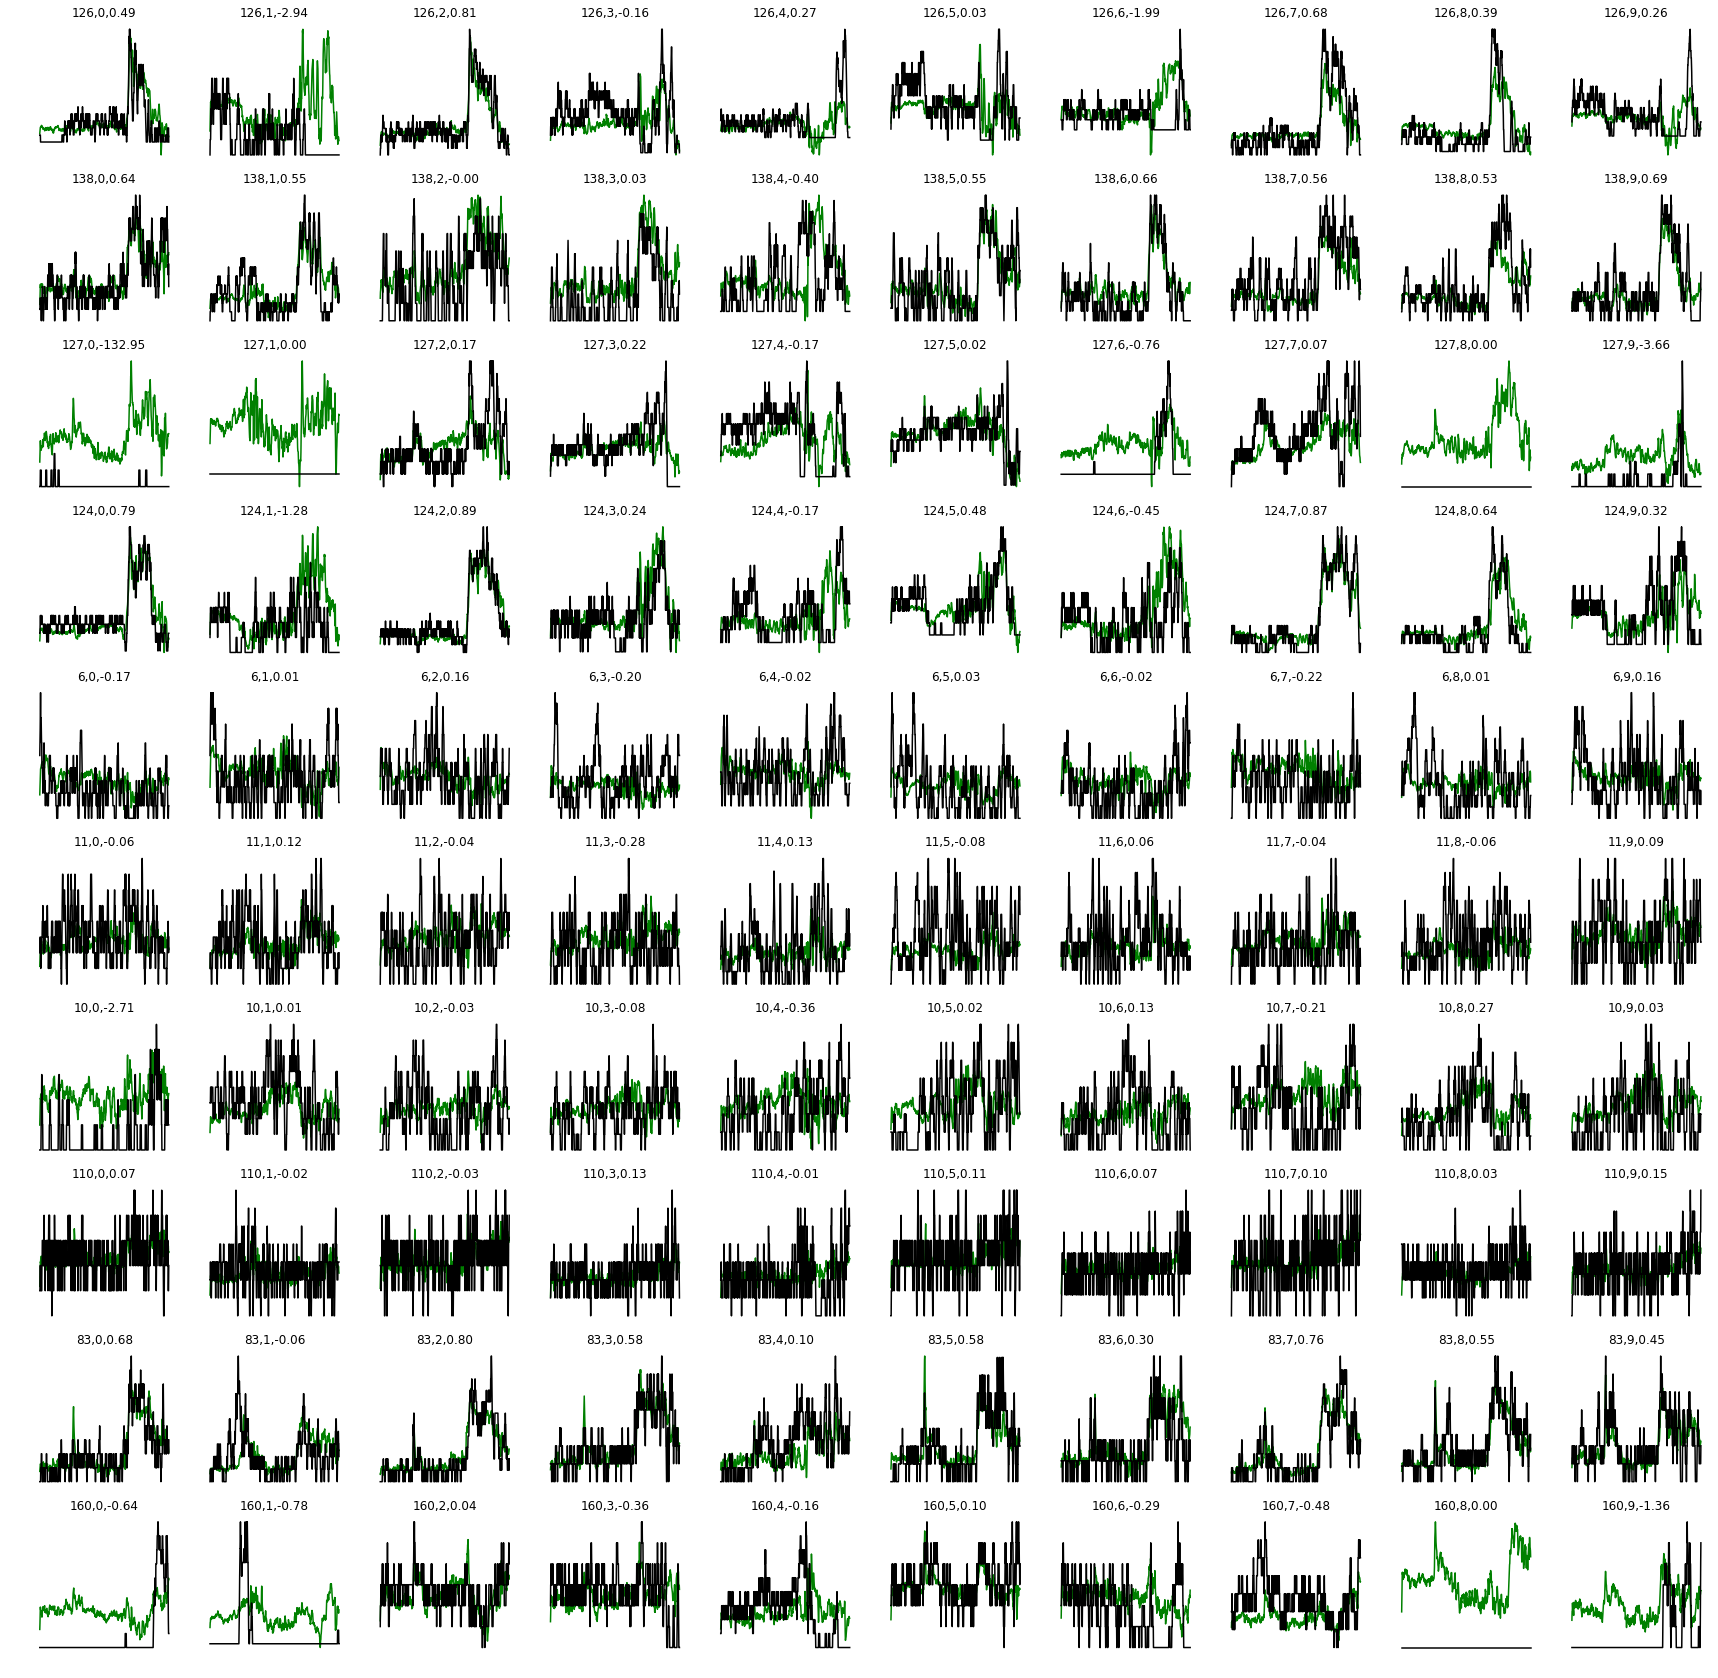

In [7]:
neuron_inds = np.argsort(single_split_r2_data['y_test'].mean(axis=(0,1)))[::-1]

plt.subplots(10,10,figsize=(30,30))

for i in range(10):
    i_neuron = neuron_inds[i]
    for j in range(10):
        i_trial = j
        plt.subplot(10,10,i*10+j+1)
        plt.plot(single_split_r2_data['y_pred'][:,i_trial,i_neuron],'g-')
        plt.plot(single_split_r2_data['y_test'][:,i_trial,i_neuron],'k-')
        plt.title('%d,%d,%.2f'%(i_neuron,i_trial,r2_score(single_split_r2_data['y_test'][:,i_trial,i_neuron],single_split_r2_data['y_pred'][:,i_trial,i_neuron])))
        plt.axis('off')



In [11]:
# what we have:
print('Embed predictions',single_split_r2_data.keys())
print('End-to-end',end_to_end_data.keys())
print('Raw ephys',ephys_data.keys())

Embed predictions dict_keys(['window_size', 'kfold', 'timeshift', 'session_name', 'r2_scores', 'y_test', 'y_pred', 'tt', 'trial_type_masks', 'test_trial_inds', 'ccf_coords', 'ccf_labels', 'ccf_unit_ids', 'is_alm'])
End-to-end dict_keys(['prediction', 'uid', 'truth'])
Raw ephys dict_keys(['sess_name', 'area', 'bin_centers', 'fr', 'spike_times', 'neuron_info', 'unit_qc', 'ccf_coordinate', 'ccf_label', 'ccf_unit_id', 'auto_learn_trials', 'early_lick_trials', 'auto_water_trials', 'free_water_trials', 'lick_directions', 'lick_times', 'gocue_time', 'correctness', 'delay_period', 'sample_period', 'stimulation', 'trial_type'])


In [14]:
e2e_fr = end_to_end_data['prediction']
e2e_raw = end_to_end_data['truth']
e2e_trial_ids = end_to_end_data['uid']
e2e_fr.shape

(62, 1220, 87)

In [15]:
raw_fr = ephys_data['fr']
e2e_neuron_ids = ephys_data['ccf_unit_id']
raw_fr.shape

(1765, 640, 87)

In [17]:
embed_fr = single_split_r2_data['y_pred']
embed_raw = single_split_r2_data['y_test']
embed_neuron_ids = single_split_r2_data['ccf_unit_ids']
embed_trial_ids = single_split_r2_data['test_trial_inds']

In [18]:
ephys_data['ccf_coordinate'].shape

(87, 3)

In [19]:
single_split_r2_data['ccf_coords'].shape

(255, 3)

In [20]:
# align the embedding neurons to the raw ephys and e2e data

neuron_alignment_inds = []

for i, neuron_id in enumerate(e2e_neuron_ids):
    possible_inds = np.where(embed_neuron_ids == neuron_id)[0]

    if len(possible_inds) == 1:
        neuron_alignment_inds.append(possible_inds[0])
    elif len(possible_inds) == 0:
        print('Neuron %d not found in embedding data'%neuron_id)
    else:
        for raw_ind in possible_inds:
            if np.allclose(ephys_data['ccf_coordinate'][i],single_split_r2_data['ccf_coords'][raw_ind]):
                neuron_alignment_inds.append(raw_ind)
                break

In [21]:
len(neuron_alignment_inds)

87

In [22]:
neuron_aligned_embed_fr = embed_fr[:,:,neuron_alignment_inds]
neuron_aligned_embed_raw = embed_raw[:,:,neuron_alignment_inds]

In [23]:
# align the trial ids

raw_e2e_trial_inds = np.array([int(ind.split('-')[-1])-1 for ind in e2e_trial_ids])

embed_trial_alignment_inds = []
e2e_trial_alignment_inds = []

for i,trial_id in enumerate(raw_e2e_trial_inds):
    if trial_id in embed_trial_ids:
        embed_trial_alignment_inds.append(np.where(embed_trial_ids == trial_id)[0][0])
        e2e_trial_alignment_inds.append(i)
    else:
        print('Trial %d not found in embedding data'%trial_id)

In [24]:
e2e_fr.shape

(62, 1220, 87)

In [26]:
aligned_embed_fr = neuron_aligned_embed_fr[:,embed_trial_alignment_inds,:]
aligned_embed_raw = neuron_aligned_embed_raw[:,embed_trial_alignment_inds,:]

aligned_e2e_fr = e2e_fr[e2e_trial_alignment_inds,:,:].swapaxes(0,1)

print(aligned_embed_fr.shape)
print(aligned_embed_raw.shape)
print(aligned_e2e_fr.shape)

(662, 62, 87)
(662, 62, 87)
(1220, 62, 87)


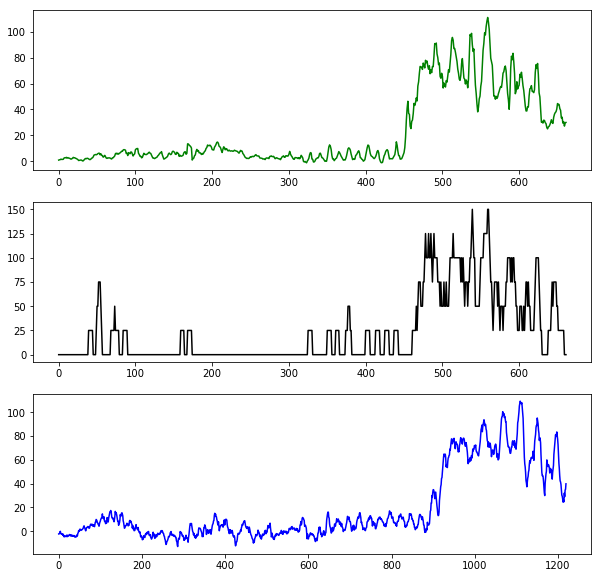

In [41]:
i_neuron = 25
i_trial = 14

plt.subplots(3,1,figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(aligned_embed_fr[:,i_trial,i_neuron],'g-')

plt.subplot(3,1,2)
plt.plot(aligned_embed_raw[:,i_trial,i_neuron],'k-')

plt.subplot(3,1,3)
plt.plot(aligned_e2e_fr[:,i_trial,i_neuron],'b-')

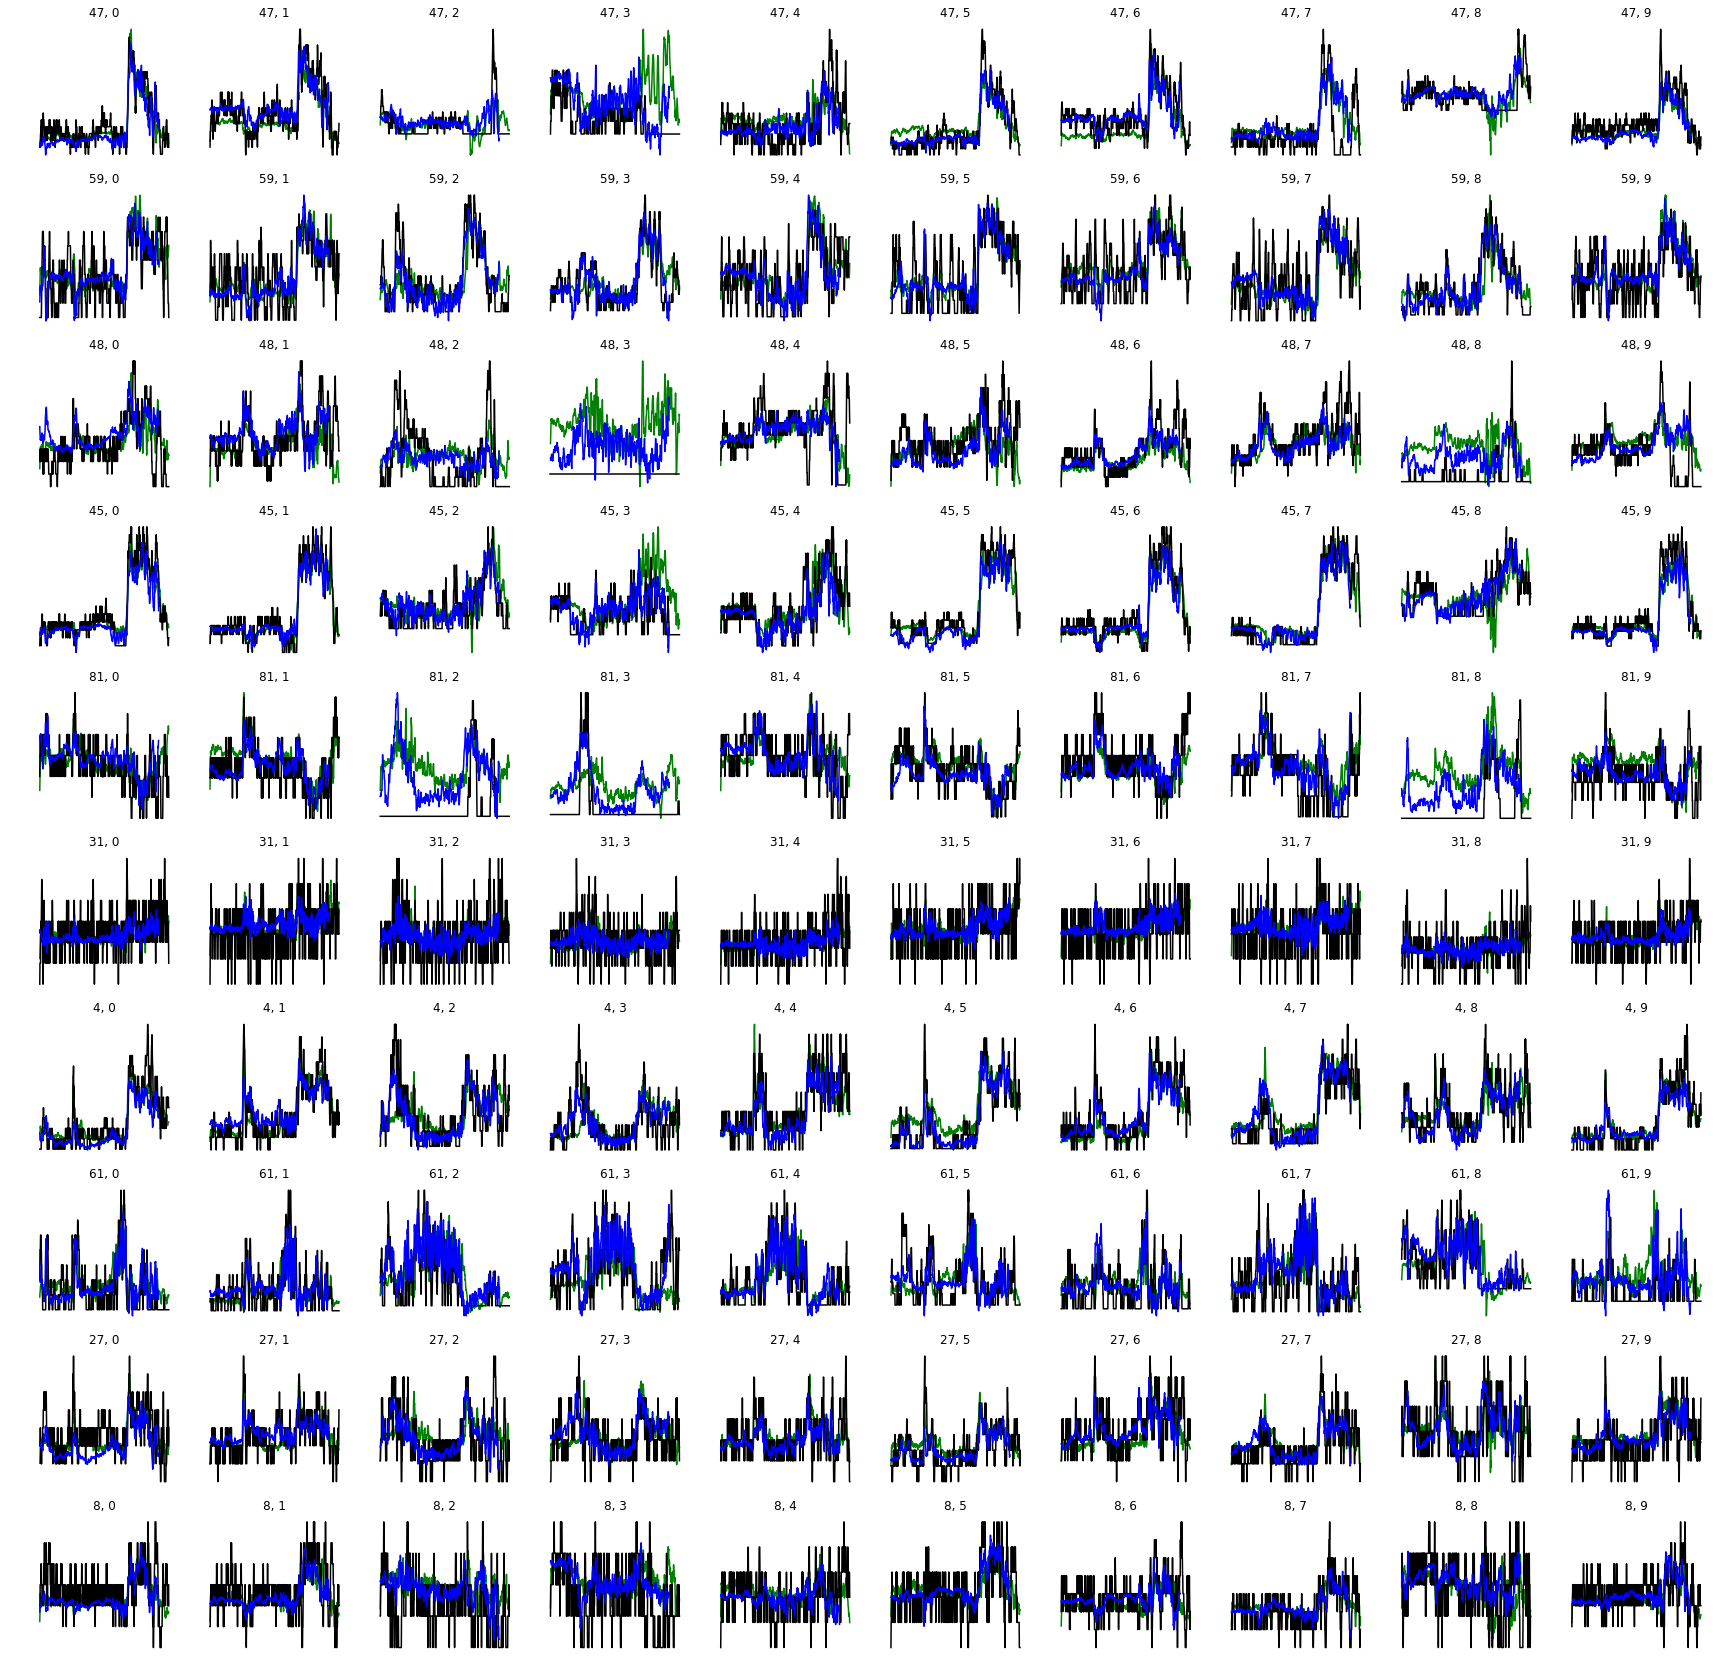

In [42]:
neuron_inds = np.argsort(aligned_embed_raw.mean(axis=(0,1)))[::-1]

plt.subplots(10,10,figsize=(30,30))

for i in range(10):
    i_neuron = neuron_inds[i]
    for j in range(10):
        i_trial = j
        plt.subplot(10,10,i*10+j+1)
        plt.plot(aligned_embed_fr[:,i_trial,i_neuron],'g-')
        plt.plot(aligned_embed_raw[:,i_trial,i_neuron],'k-')
        plt.plot(aligned_e2e_fr[1::2,i_trial,i_neuron],'b-')

        plt.title('%d, %d'%(i_neuron,i_trial,))
        plt.axis('off')



In [51]:
e2e_fr.shape

(62, 1220, 87)

In [43]:
tt = single_split_r2_data['tt']

In [46]:
tmask = (tt>=-3) & (tt<=1.2)

In [50]:
tt[tmask].shape

(618,)

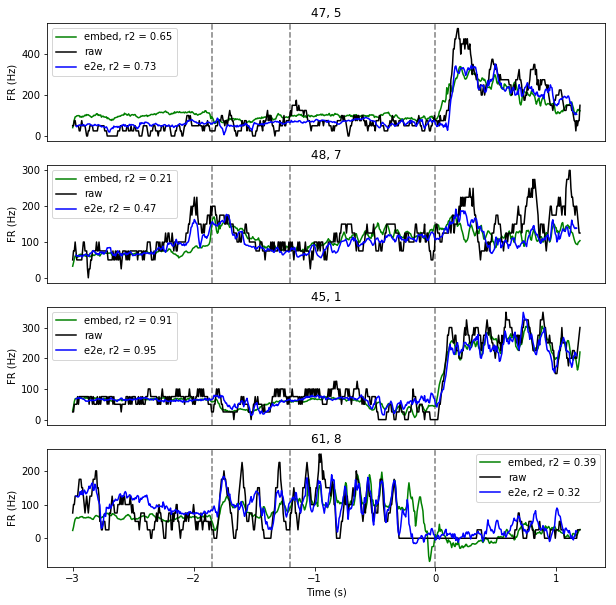

In [58]:
select_inds = [
    (47,5),
    (48,7),
    (45,1),
    (61,8)
]


plt.subplots(4,1,figsize=(10,10))

for i, (i_neuron, i_trial) in enumerate(select_inds):
    plt.subplot(4,1,i+1)
    plt.plot(tt[tmask],aligned_embed_fr[tmask,i_trial,i_neuron],'g-', label = 'embed, r2 = %.2f'%r2_score(aligned_embed_raw[tmask,i_trial,i_neuron],aligned_embed_fr[tmask,i_trial,i_neuron]))
    plt.plot(tt[tmask],aligned_embed_raw[tmask,i_trial,i_neuron],'k-', label = 'raw')
    plt.plot(tt[tmask][4:-4],aligned_e2e_fr[::2,i_trial,i_neuron],'b-', label = 'e2e, r2 = %.2f'%r2_score(aligned_e2e_fr[::2,i_trial,i_neuron],aligned_embed_fr[tmask,i_trial,i_neuron][4:-4]))
    plt.title('%d, %d'%(i_neuron,i_trial,))
    if i == len(select_inds)-1:
        plt.xlabel('Time (s)')
    else:
        plt.xticks([])

    a,b = plt.ylim()
    plt.vlines([-1.85,-1.2,0],a,b,linestyles='dashed',colors='grey')
    plt.ylim(a,b)

    plt.ylabel('FR (Hz)')
    plt.legend()

plt.savefig('../figs/end_to_end/example_single_trials.png')

In [60]:
neuron_number_fname = '../data/neuron_number_dict.pickle'

with open(neuron_number_fname, 'rb') as f:
    neuron_number_dict = pickle.load(f)

neuron_number_dict.keys()

dict_keys(['/oak/stanford/groups/shauld/kurgyis/data/Map_ULTIMATE_preprocessed/stride3_bw40/SC035_20200110_36/3_right_Midbrain.pickle', '/oak/stanford/groups/shauld/kurgyis/data/Map_ULTIMATE_preprocessed/stride3_bw40/SC035_20200110_36/1_right_ALM.pickle', '/oak/stanford/groups/shauld/kurgyis/data/Map_ULTIMATE_preprocessed/stride3_bw40/SC035_20200110_36/4_right_Orbital.pickle', '/oak/stanford/groups/shauld/kurgyis/data/Map_ULTIMATE_preprocessed/stride3_bw40/SC035_20200110_36/2_left_Medulla.pickle', '/oak/stanford/groups/shauld/kurgyis/data/Map_ULTIMATE_preprocessed/stride3_bw40/SC035_20200110_36/5_right_OtherCortex.pickle', '/oak/stanford/groups/shauld/kurgyis/data/Map_ULTIMATE_preprocessed/stride3_bw40/SC060_20210323_5/1_right_ALM.pickle', '/oak/stanford/groups/shauld/kurgyis/data/Map_ULTIMATE_preprocessed/stride3_bw40/SC060_20210323_5/4_right_Orbital.pickle', '/oak/stanford/groups/shauld/kurgyis/data/Map_ULTIMATE_preprocessed/stride3_bw40/SC060_20210323_5/2_right_Midbrain.pickle', '/o

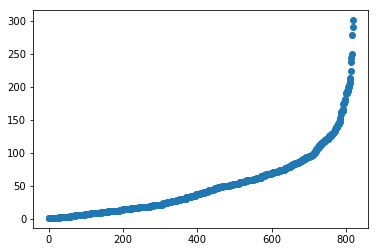

In [62]:
numbers = np.array(list(neuron_number_dict.values()))
neuron_inds = np.argsort(numbers)

plt.plot(numbers[neuron_inds], 'o')

In [63]:
np.sum(numbers > 100)

103

# Compare methods on new run

In [2]:
base_hdd_folder = '/media/kurgyis/TOSHIBA EXT/balint/Data/'
embed_folder = base_hdd_folder + 'embed_single_split/'
marker_folder = base_hdd_folder + 'marker_single_split/'
e2e_folder = base_hdd_folder + 'end-to-end_single_split/'

raw_ephys_folder = base_hdd_folder + 'Map_ULTIMATE_preprocessed/stride3_bw40/'

embed_files = os.listdir(embed_folder)
marker_files = os.listdir(marker_folder)
e2e_files = [f for f in os.listdir(e2e_folder) if f.endswith('.tar')]
raw_ephys_files = os.listdir(raw_ephys_folder)

In [18]:
e2e_files

['SC045_121120-652-25000-a4-rightStriatum-pred.tar',
 'SC026_080519-521-25000-a3-rightMidbrain-pred.tar',
 'SC026_080819-523-25000-a1-leftALM-pred.tar',
 'SC027_072919-524-25000-a3-rightMidbrain-pred.tar',
 'SC027_073019-525-25000-a2-rightALM-pred.tar',
 'SC027_080419-529-25000-a2-rightStriatum-pred.tar',
 'SC030_100519-542-25000-a2-rightALM-pred.tar',
 'SC031_102119-543-25000-a4-rightMedulla-pred.tar',
 'SC032_121919-556-25000-a3-rightMidbrain-pred.tar',
 'SC035_010820-589-25000-a3-leftMidbrain-pred.tar',
 'SC043_092420-649-25000-a3-leftMedulla-pred.tar',
 'SC048_010421-662-25000-a2-rightMidbrain-pred.tar',
 'SC048_122520-663-25000-a2-rightMidbrain-pred.tar',
 'SC050_022721-593-25000-a2-rightALM-pred.tar',
 'SC052_012621-599-25000-a3-rightThalamus-pred.tar',
 'SC053_022521-603-25000-a3-rightStriatum-pred.tar',
 'SC060_032021-606-25000-a3-leftThalamus-pred.tar',
 'SC060_032221-607-25000-a3-rightStriatum-pred.tar',
 'SC061_032221-616-25000-a1-rightALM-pred.tar',
 'SC061_032221-616-25000

In [19]:
raw_ephys_files

['SC011_20190219_1',
 'SC011_20190220_2',
 'SC026_20190805_21',
 'SC030_20191005_35',
 'SC035_20200108_34',
 'SC038_20191122_10',
 'SC043_20200925_27']

In [25]:
e2e_file = 'SC035_010820-589-25000-a3-leftMidbrain-pred.tar'

e2e_data = torch.load(e2e_folder + e2e_file)

_session_name = e2e_file.split('-')[0]
session_name = _session_name[:5] + '_20' + _session_name[-2:] + _session_name[-6:-2]
_brain_region = e2e_file.split('-')[4]
if "left" in _brain_region:
    brain_region = 'left_' + _brain_region[4:]
else:
    brain_region = 'right_' + _brain_region[5:]

brain_region

'left_Midbrain'

In [29]:
embed_file = [f for f in embed_files if session_name in f][0]
marker_file = [f for f in marker_files if session_name in f][0]

embed_data = pickle.load(open(embed_folder + embed_file, 'rb'))
marker_data = pickle.load(open(marker_folder + marker_file, 'rb'))

ephys_folder = [f for f in raw_ephys_files if session_name in f][0]
ephys_file = [f for f in os.listdir(raw_ephys_folder + ephys_folder) if brain_region in f][0]
ephys_data = pickle.load(open(raw_ephys_folder + ephys_folder +'/' + ephys_file, 'rb'))

In [23]:
os.listdir(raw_ephys_folder + ephys_folder) 

['1_left_ALM.pickle',
 '2_right_Medulla.pickle',
 '3_left_Midbrain.pickle',
 '4_left_Orbital.pickle',
 '5_left_OtherCortex.pickle',
 'others_finished.txt']

In [30]:
e2e_data.keys()

dict_keys(['prediction', 'uid', 'truth'])

In [31]:
embed_data.keys()

dict_keys(['window_size', 'kfold', 'timeshift', 'session_name', 'r2_scores', 'y_test', 'y_pred', 'tt', 'trial_type_masks', 'test_trial_inds', 'ccf_coords', 'ccf_labels', 'ccf_unit_ids', 'is_alm'])

In [34]:
y_data = embed_data['y_test']
y_data_marker = marker_data['y_test']
y_embed = embed_data['y_pred']
y_marker = marker_data['y_pred']
y_e2e = e2e_data['prediction'].swapaxes(0,1)
t_embed = embed_data['tt']
t_marker = marker_data['tt']
ccf_coords = embed_data['ccf_coords']
ccf_coords_marker = marker_data['ccf_coords']

print(y_data.shape)
print(np.isclose(y_data,y_data_marker).all())
print(y_embed.shape, y_marker.shape, y_e2e.shape)
print(np.allclose(ccf_coords,ccf_coords_marker))

(1324, 64, 255)
True
(1324, 64, 255) (1324, 64, 255) (1220, 64, 79)
True


In [36]:
print(ephys_data.keys())
e2e_ccf_coords = ephys_data['ccf_coordinate']

n_neuron_e2e = y_e2e.shape[2]

start_ind = 0

for i in range(y_embed.shape[2]-n_neuron_e2e):
    if np.allclose(ccf_coords[i:i+n_neuron_e2e],e2e_ccf_coords):
        print(i)
        start_ind = i

dict_keys(['sess_name', 'area', 'bin_centers', 'fr', 'spike_times', 'neuron_info', 'unit_qc', 'ccf_coordinate', 'ccf_label', 'ccf_unit_id', 'auto_learn_trials', 'early_lick_trials', 'auto_water_trials', 'free_water_trials', 'lick_directions', 'lick_times', 'gocue_time', 'correctness', 'delay_period', 'sample_period', 'stimulation', 'trial_type'])
0


In [45]:
i = start_ind
np.allclose(ccf_coords[i:i+n_neuron_e2e],e2e_ccf_coords)

True

In [97]:
e2e_uids = e2e_data['uid']
embed_trial_inds = embed_data['test_trial_inds']
marker_trial_inds = marker_data['test_trial_inds']
e2e_trial_inds = [int(uid.split('-')[-1])-1 for uid in e2e_uids]
e2e_trial_alignment_inds = [np.where(e2e_trial_inds == trial_id)[0][0] for trial_id in embed_trial_inds]

print(np.allclose(np.array(e2e_trial_inds)[e2e_trial_alignment_inds],embed_trial_inds))

True


In [98]:
fr_data = y_data[:,:,start_ind:start_ind+n_neuron_e2e]
fr_embed = y_embed[:,:,start_ind:start_ind+n_neuron_e2e]
fr_marker = y_marker[:,:,start_ind:start_ind+n_neuron_e2e]
fr_e2e = y_e2e[:,e2e_trial_alignment_inds,:]

In [99]:
high_fr_neuron_inds = np.argsort(fr_data.mean(axis=(0,1)))[::-1]

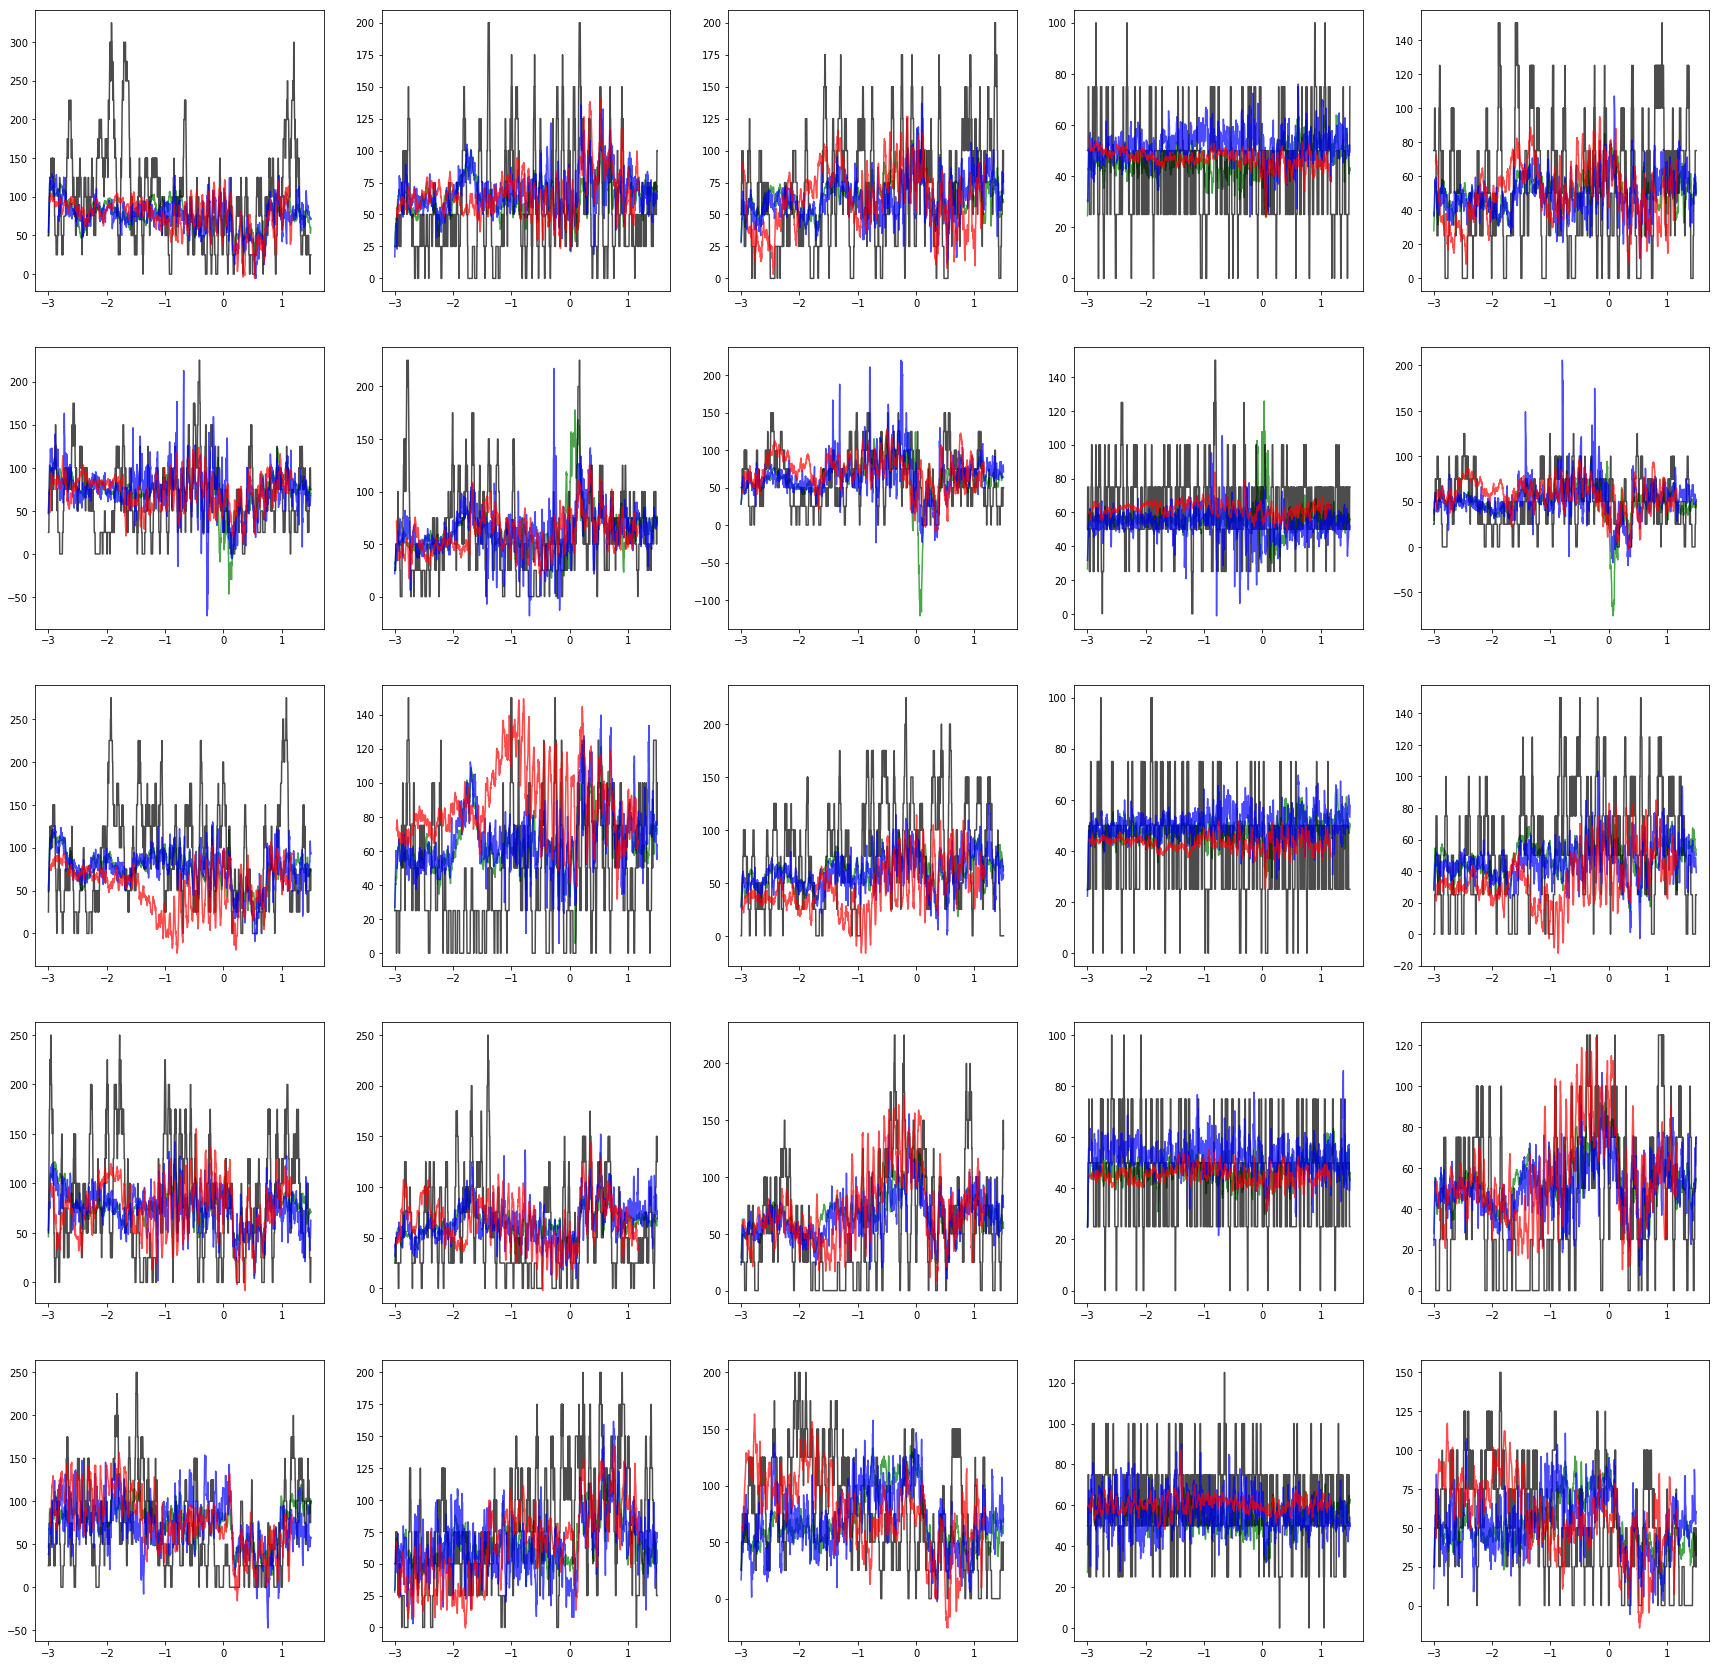

In [100]:
plt.subplots(5,5,figsize=(30,30))

for itrial in range(5):
    for ineuron in range(5):
        plt.subplot(5,5,itrial*5+ineuron+1)
        neuron_ind = high_fr_neuron_inds[ineuron]
        plt.plot(t_embed,fr_embed[:,itrial,neuron_ind],'g-', alpha = 0.7)
        plt.plot(t_embed,fr_data[:,itrial,neuron_ind],'k-', alpha = 0.7)
        plt.plot(t_embed,fr_marker[:,itrial,neuron_ind],'b-', alpha = 0.7)
        plt.plot(t_e2e,fr_e2e[:,itrial,neuron_ind],'r-', alpha = 0.7)
        #plt.axis('off')

In [101]:
FRAME_LIST_LONG = [-882,-877,-872,-867,-862,-857,-852,-847,-842,-837,-832,-827,-822,-817,-812,-807,-802,-797,-792,-787,-782,-777,-772,-767,-762,-757,-752,-747,-742,-737,-732,-727,-722,-717,-712,-707,-702,-697,-692,-687,-682,-677,-672,-667,-662,-657,-652,-647,-642,-637,-632,-627,-622,-617,-612,-607,-602,-597,-592,-587,-582,-577,-572,-567,-562,-557,-552,-547,-542,-537,-532,-527,-522,-517,-512,-507,-502,-497,-492,-487,-482,-477,-472,-467,-462,-457,-452,-447,-442,-437,-432,-427,-422,-417,-412,-407,-402,-397,-392,-387,-382,-377,-372,-367,-362,-357,-352,-347,-342,-337,-332,-327,-322,-317,-312,-307,-302,-297,-292,-287,-282,-277,-272,-267,-262,-257,-252,-247,-242,-237,-232,-227,-222,-217,-212,-207,-202,-197,-192,-187,-182,-177,-172,-167,-162,-157,-152,-147,-142,-137,-132,-127,-122,-117,-112,-107,-102,-97,-92,-87,-82,-77,-72,-67,-62,-57,-52,-47,-42,-37,-32,-27,-22,-17,-12,-7,-2,3,8,13,18,23,28,33,38,43,48,53,58,63,68,73,78,83,88,93,98,103,108,113,118,123,128,133,138,143,148,153,158,163,168,173,178,183,188,193,198,203,208,213,218,223,228,233,238,243,248,253,258,263,268,273,278,283,288,293,298,303,308,313,318,323,328,333,338,343,348,353]

FRAME_LIST = FRAME_LIST_LONG[8:-8]

len(FRAME_LIST), len(FRAME_LIST_LONG)

(232, 248)

In [102]:
t_e2e = 0.0034 * np.arange(-882,354)[8:-8]

In [103]:
t_e2e

array([-2.9716, -2.9682, -2.9648, ...,  1.1662,  1.1696,  1.173 ])

In [104]:
t_embed[8:-96]

array([-2.9728, -2.9694, -2.966 , ...,  1.165 ,  1.1684,  1.1718])

In [105]:
t_e2e = 0.0034 * np.arange(-882,354)[8:-8]
fr_data_e2e_aligned = fr_data[8:-96:,]

In [106]:
from sklearn.metrics import r2_score

In [128]:
e2e_r2 = np.zeros((t_e2e.shape[0],n_neuron_e2e))
for t in range(t_e2e.shape[0]):
    e2e_r2[t,:] = r2_score(fr_data_e2e_aligned[t,:],fr_e2e[t,:], multioutput= 'raw_values')

embed_r2 = embed_data['r2_scores'].squeeze()
marker_r2 = marker_data['r2_scores'].squeeze()

In [129]:
embed_time_mask = (t_embed >= 0.15) & (t_embed <= 1.2)
e2e_time_mask = (t_e2e >= 0.15) & (t_e2e <= 1.2)

relu = lambda x: np.maximum(x,0)

response_r2_e2e = relu(e2e_r2)[e2e_time_mask,].mean(axis=0)
response_r2_embed = relu(embed_r2)[embed_time_mask,].mean(axis=0)[start_ind:start_ind+n_neuron_e2e]
response_r2_marker = relu(marker_r2)[embed_time_mask,].mean(axis=0)[start_ind:start_ind+n_neuron_e2e]

In [ ]:
embed_over_marker = np.mean((response_r2_embed/response_r2_marker) - 1)
e2e_over_embed = np.mean((response_r2_e2e/response_r2_embed) - 1)
e2e_over_marker = np.mean((response_r2_e2e/response_r2_marker) - 1)

In [11]:
figfolder = '../figs/end_to_end/single_session_scatters/'
os.makedirs(figfolder, exist_ok = True)

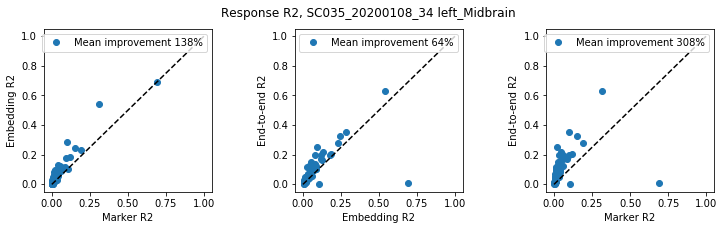

In [155]:
f,_ = plt.subplots(1,3, figsize = (12,3))
f.subplots_adjust(wspace=0.5)
f.suptitle('Response R2, %s'%ephys_folder + ' ' + brain_region)

plt.subplot(1,3,1)
plt.plot(response_r2_marker, response_r2_embed, 'o', label = 'Mean improvement {:.0%}'.format(embed_over_marker))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Marker R2')
plt.ylabel('Embedding R2')
plt.legend()

plt.subplot(1,3,2)
plt.plot(response_r2_embed, response_r2_e2e, 'o', label = 'Mean improvement {:.0%}'.format(e2e_over_embed))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Embedding R2')
plt.ylabel('End-to-end R2')
plt.legend()

plt.subplot(1,3,3)
plt.plot(response_r2_marker, response_r2_e2e, 'o', label = 'Mean improvement {:.0%}'.format(e2e_over_marker))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Marker R2')
plt.ylabel('End-to-end R2')
plt.legend()

plt.savefig(figfolder + '%s_%s_response_r2.png'%(ephys_folder,brain_region), dpi = 300, bbox_inches = 'tight')

In [133]:
embed_over_marker = np.mean((response_r2_embed/response_r2_marker) - 1)
e2e_over_embed = np.mean((response_r2_e2e/response_r2_embed) - 1)
e2e_over_marker = np.mean((response_r2_e2e/response_r2_marker) - 1)

embed_over_marker, e2e_over_embed, e2e_over_marker


(1.3833188876637423, 0.6377617050159119, 3.0801258484639225)

In [21]:
base_hdd_folder = '/media/kurgyis/TOSHIBA EXT/balint/Data/'
embed_folder = base_hdd_folder + 'embed_single_split/'
marker_folder = base_hdd_folder + 'marker_single_split/'
e2e_folder = base_hdd_folder + 'end-to-end_single_split/'

raw_ephys_folder = base_hdd_folder + 'Map_ULTIMATE_preprocessed/stride3_bw40/'

embed_files = os.listdir(embed_folder)
marker_files = os.listdir(marker_folder)
e2e_files = [f for f in os.listdir(e2e_folder) if f.endswith('.tar')]
raw_ephys_files = os.listdir(raw_ephys_folder)

In [22]:
e2e_files

['SC045_121120-652-25000-a4-rightStriatum-pred.tar',
 'SC026_080519-521-25000-a3-rightMidbrain-pred.tar',
 'SC026_080819-523-25000-a1-leftALM-pred.tar',
 'SC027_072919-524-25000-a3-rightMidbrain-pred.tar',
 'SC027_073019-525-25000-a2-rightALM-pred.tar',
 'SC027_080419-529-25000-a2-rightStriatum-pred.tar',
 'SC030_100519-542-25000-a2-rightALM-pred.tar',
 'SC031_102119-543-25000-a4-rightMedulla-pred.tar',
 'SC032_121919-556-25000-a3-rightMidbrain-pred.tar',
 'SC035_010820-589-25000-a3-leftMidbrain-pred.tar',
 'SC043_092420-649-25000-a3-leftMedulla-pred.tar',
 'SC048_010421-662-25000-a2-rightMidbrain-pred.tar',
 'SC048_122520-663-25000-a2-rightMidbrain-pred.tar',
 'SC050_022721-593-25000-a2-rightALM-pred.tar',
 'SC052_012621-599-25000-a3-rightThalamus-pred.tar',
 'SC053_022521-603-25000-a3-rightStriatum-pred.tar',
 'SC060_032021-606-25000-a3-leftThalamus-pred.tar',
 'SC060_032221-607-25000-a3-rightStriatum-pred.tar',
 'SC061_032221-616-25000-a1-rightALM-pred.tar',
 'SC061_032221-616-25000

In [23]:
raw_ephys_files

['SC011_20190219_1',
 'SC011_20190220_2',
 'SC026_20190805_21',
 'SC026_20190808_23',
 'SC027_20190729_17',
 'SC027_20190730_18',
 'SC027_20190804_22',
 'SC030_20191005_35',
 'SC035_20200108_34',
 'SC038_20191122_10',
 'SC043_20200925_27']

In [24]:
figfolder = '../figs/end_to_end/single_session_scatters/'
os.makedirs(figfolder, exist_ok = True)

In [25]:
save_folder = base_hdd_folder + 'combined_methods_r2/'

In [26]:
relu = lambda x: np.maximum(x,0)

No ephys data found for session SC045_20201211
0


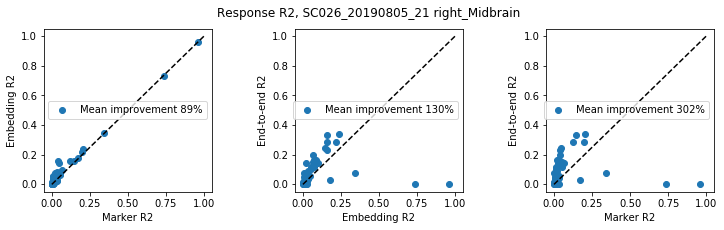

392


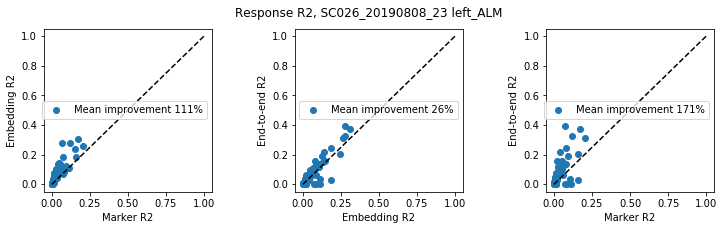

0


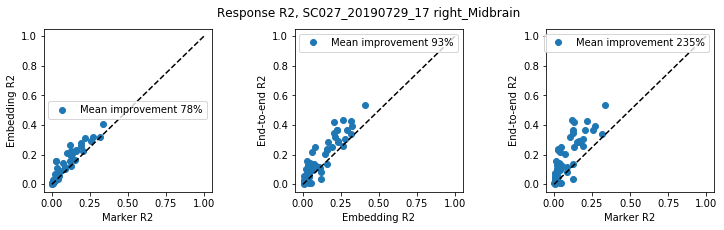

122


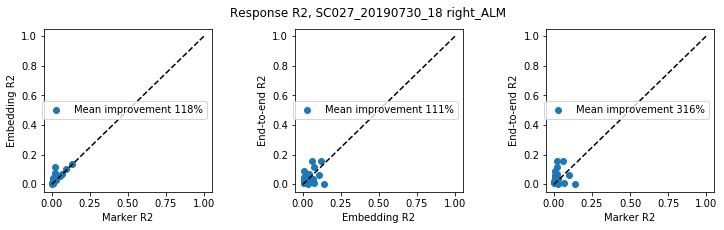

239


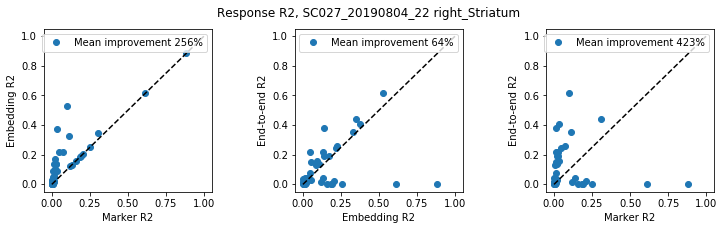

150


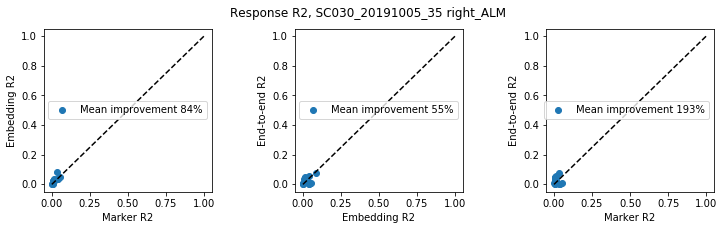

No ephys data found for session SC031_20191021
No ephys data found for session SC032_20191219
0


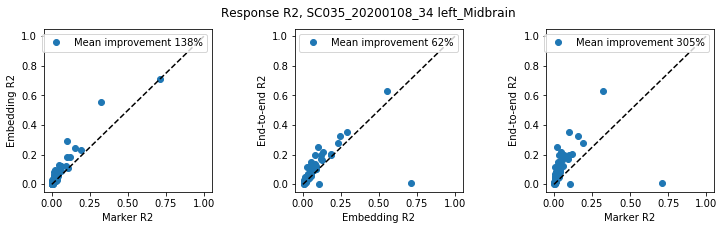

No ephys data found for session SC043_20200924
No ephys data found for session SC048_20210104
No ephys data found for session SC048_20201225
No ephys data found for session SC050_20210227
No ephys data found for session SC052_20210126
No ephys data found for session SC053_20210225
No ephys data found for session SC060_20210320
No ephys data found for session SC060_20210322
No ephys data found for session SC061_20210322
No ephys data found for session SC061_20210322
No ephys data found for session SC064_20210504
No ephys data found for session SC064_20210506
No ephys data found for session SC064_20210508
No ephys data found for session SC065_20210507
No ephys data found for session SC065_20210510
No ephys data found for session SC065_20210510
No ephys data found for session SC066_20210416


In [28]:
#e2e_file = 'SC035_010820-589-25000-a3-leftMidbrain-pred.tar' #'SC026_080819-523-25000-a1-leftALM-pred.tar' # 'SC026_080519-521-25000-a3-rightMidbrain-pred.tar' # 'SC027_072919-524-25000-a3-rightMidbrain-pred.tar'

for e2e_file in e2e_files:

    e2e_data = torch.load(e2e_folder + e2e_file)

    _session_name = e2e_file.split('-')[0]
    if '_s' in _session_name:
        end = _session_name.split('_s')[-1]
        _session_name = _session_name.split('_s')[0]
        session_name = _session_name[:5] + '_20' + _session_name[-2:] + _session_name[-6:-2] + '_' + end
    else:
        session_name = _session_name[:5] + '_20' + _session_name[-2:] + _session_name[-6:-2]
    _brain_region = e2e_file.split('-')[4]
    if "left" in _brain_region:
        brain_region = 'left_' + _brain_region[4:]
    else:
        brain_region = 'right_' + _brain_region[5:]

    ephys_session = [f for f in raw_ephys_files if session_name in f]

    if len(ephys_session) == 0:
        print('No ephys data found for session %s'%session_name)
        continue

    embed_file = [f for f in embed_files if session_name in f][0]
    marker_file = [f for f in marker_files if session_name in f][0]

    embed_data = pickle.load(open(embed_folder + embed_file, 'rb'))
    marker_data = pickle.load(open(marker_folder + marker_file, 'rb'))

    ephys_folder = [f for f in raw_ephys_files if session_name in f][0]
    ephys_file = [f for f in os.listdir(raw_ephys_folder + ephys_folder) if brain_region in f][0]
    ephys_data = pickle.load(open(raw_ephys_folder + ephys_folder +'/' + ephys_file, 'rb'))

    y_data = embed_data['y_test']
    y_embed = embed_data['y_pred']
    y_marker = marker_data['y_pred']

    y_e2e = e2e_data['prediction'].swapaxes(0,1)
    t_embed = embed_data['tt']
    ccf_coords = embed_data['ccf_coords']

    embed_t_mask = (t_embed >= -3) & (t_embed <= 1.2)
    embed_t_inds = np.where(embed_t_mask)[0]
    embed_t_inds = embed_t_inds[8:-8]

    t_embed = t_embed[embed_t_inds]
    y_data = y_data[embed_t_inds,:,:]
    y_embed = y_embed[embed_t_inds,:,:]
    y_marker = y_marker[embed_t_inds,:,:]

    e2e_ccf_coords = ephys_data['ccf_coordinate']
    e2e_ccf_labels = ephys_data['ccf_label']
    e2e_ccf_uids = ephys_data['ccf_unit_id']

    n_neuron_e2e = y_e2e.shape[2]

    start_ind = 0

    for i in range(y_embed.shape[2]-n_neuron_e2e):
        if np.allclose(ccf_coords[i:i+n_neuron_e2e],e2e_ccf_coords):
            print(i)
            start_ind = i

    e2e_uids = e2e_data['uid']
    embed_trial_inds = embed_data['test_trial_inds']
    marker_trial_inds = marker_data['test_trial_inds']
    e2e_trial_inds = [int(uid.split('-')[-1])-1 for uid in e2e_uids]
    e2e_trial_alignment_inds = [np.where(e2e_trial_inds == trial_id)[0][0] for trial_id in embed_trial_inds]

    fr_data = y_data[:,:,start_ind:start_ind+n_neuron_e2e]
    fr_embed = y_embed[:,:,start_ind:start_ind+n_neuron_e2e]
    fr_marker = y_marker[:,:,start_ind:start_ind+n_neuron_e2e]
    fr_e2e = y_e2e[:,e2e_trial_alignment_inds,:]

    tt = ephys_data['bin_centers']
    tmask = (tt>=-3) & (tt<=1.2)
    t_e2e = tt[tmask][8:-8]

    #fr_data_e2e_aligned = fr_data[8:-96:,]
    fr_data_e2e_aligned = ephys_data['fr'][tmask][8:-8][:,embed_trial_inds]

    e2e_r2 = np.zeros((t_e2e.shape[0],n_neuron_e2e))
    for t in range(t_e2e.shape[0]):
        e2e_r2[t,:] = r2_score(fr_data_e2e_aligned[t,:],fr_e2e[t,:], multioutput= 'raw_values')

    embed_r2 = embed_data['r2_scores'].squeeze()[embed_t_inds]
    marker_r2 = marker_data['r2_scores'].squeeze()[embed_t_inds]

    embed_time_mask = (t_embed >= 0.15) & (t_embed <= 1.2)
    e2e_time_mask = (t_e2e >= 0.15) & (t_e2e <= 1.2)
    response_r2_e2e = relu(e2e_r2)[e2e_time_mask,].mean(axis=0)
    response_r2_embed = relu(embed_r2)[embed_time_mask,].mean(axis=0)[start_ind:start_ind+n_neuron_e2e]
    response_r2_marker = relu(marker_r2)[embed_time_mask,].mean(axis=0)[start_ind:start_ind+n_neuron_e2e]

    sample_embed_mask = (t_embed >= -1.7) & (t_embed <= -1.35)
    sample_e2e_mask = (t_e2e >= -1.7) & (t_e2e <= -1.35)

    delay_embed_mask = (t_embed >= -1.05) & (t_embed <= -0.15)
    delay_e2e_mask = (t_e2e >= -1.05) & (t_e2e <= -0.15)

    sample_r2_e2e = relu(e2e_r2)[sample_e2e_mask,].mean(axis=0)
    sample_r2_embed = relu(embed_r2)[sample_embed_mask,].mean(axis=0)[start_ind:start_ind+n_neuron_e2e]
    sample_r2_marker = relu(marker_r2)[sample_embed_mask,].mean(axis=0)[start_ind:start_ind+n_neuron_e2e]

    delay_r2_e2e = relu(e2e_r2)[delay_e2e_mask,].mean(axis=0)
    delay_r2_embed = relu(embed_r2)[delay_embed_mask,].mean(axis=0)[start_ind:start_ind+n_neuron_e2e]
    delay_r2_marker = relu(marker_r2)[delay_embed_mask,].mean(axis=0)[start_ind:start_ind+n_neuron_e2e]

    save_dict = {
        'tt': t_e2e,
        'fr_true': fr_data_e2e_aligned,
        'fr_embed': fr_embed,
        'fr_marker': fr_marker,
        'fr_e2e': fr_e2e,
        'ccf_coords': e2e_ccf_coords,
        'ccf_labels': e2e_ccf_labels,
        'ccf_unit_ids': e2e_ccf_uids,
        'response_r2_embed': response_r2_embed,
        'response_r2_marker': response_r2_marker,
        'response_r2_e2e': response_r2_e2e,
        'sample_r2_embed': sample_r2_embed,
        'sample_r2_marker': sample_r2_marker,
        'sample_r2_e2e': sample_r2_e2e,
        'delay_r2_embed': delay_r2_embed,
        'delay_r2_marker': delay_r2_marker,
        'delay_r2_e2e': delay_r2_e2e,
        'session_name': ephys_folder,
    }

    save_fname = save_folder + session_name + '_' + brain_region + '.pickle'
    with open(save_fname, 'wb') as f:
        pickle.dump(save_dict, f)

    embed_over_marker = np.mean((response_r2_embed/response_r2_marker) - 1)
    e2e_over_embed = np.mean((response_r2_e2e/response_r2_embed) - 1)
    e2e_over_marker = np.mean((response_r2_e2e/response_r2_marker) - 1)

    f,_ = plt.subplots(1,3, figsize = (12,3))
    f.subplots_adjust(wspace=0.5)
    f.suptitle('Response R2, %s'%ephys_folder + ' ' + brain_region)

    plt.subplot(1,3,1)
    plt.plot(response_r2_marker, response_r2_embed, 'o', label = 'Mean improvement {:.0%}'.format(embed_over_marker))
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('Marker R2')
    plt.ylabel('Embedding R2')
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(response_r2_embed, response_r2_e2e, 'o', label = 'Mean improvement {:.0%}'.format(e2e_over_embed))
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('Embedding R2')
    plt.ylabel('End-to-end R2')
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(response_r2_marker, response_r2_e2e, 'o', label = 'Mean improvement {:.0%}'.format(e2e_over_marker))
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('Marker R2')
    plt.ylabel('End-to-end R2')
    plt.legend()

    plt.savefig(figfolder + '%s_%s_response_r2.png'%(ephys_folder,brain_region), dpi = 300, bbox_inches = 'tight')
    plt.show()
    plt.close()

In [16]:
combined_method_folder = '/oak/stanford/groups/shauld/kurgyis/data/combined_methods_r2/'

files = os.listdir(combined_method_folder)

r2_e2e_response = []
r2_embed_response = []
r2_marker_response = []
r2_e2e_sample = []
r2_embed_sample = []
r2_marker_sample = []
r2_e2e_delay = []
r2_embed_delay = []
r2_marker_delay = []
ccf_label = []
ccf_coords = []
is_alm = []
session_name = []
avg_fr = []


for f in files:
    with open(combined_method_folder + f, 'rb') as f:
        data = pickle.load(f)
        r2_e2e_response.append(data['response_r2_e2e'])
        r2_embed_response.append(data['response_r2_embed'])
        r2_marker_response.append(data['response_r2_marker'])
        r2_e2e_sample.append(data['sample_r2_e2e'])
        r2_embed_sample.append(data['sample_r2_embed'])
        r2_marker_sample.append(data['sample_r2_marker'])
        r2_e2e_delay.append(data['delay_r2_e2e'])
        r2_embed_delay.append(data['delay_r2_embed'])
        r2_marker_delay.append(data['delay_r2_marker'])
        ccf_label.append(data['ccf_labels'])
        ccf_coords.append(data['ccf_coords'])
        session_name.append(np.array([data['session_name'] for _ in range(len(data['ccf_labels']))]))
        is_alm.append(np.array(['ALM' in f for _ in range(len(data['ccf_labels']))]))
        avg_fr.append(np.mean(data['fr_true'], axis = (0,1)))

r2_e2e_response = np.concatenate(r2_e2e_response)
r2_embed_response = np.concatenate(r2_embed_response)
r2_marker_response = np.concatenate(r2_marker_response)
r2_e2e_sample = np.concatenate(r2_e2e_sample)
r2_embed_sample = np.concatenate(r2_embed_sample)
r2_marker_sample = np.concatenate(r2_marker_sample)
r2_e2e_delay = np.concatenate(r2_e2e_delay)
r2_embed_delay = np.concatenate(r2_embed_delay)
r2_marker_delay = np.concatenate(r2_marker_delay)
ccf_label = np.concatenate(ccf_label)
ccf_coords = np.concatenate(ccf_coords, axis = 0)
session_name = np.concatenate(session_name)
is_alm = np.concatenate(is_alm)
avg_fr = np.concatenate(avg_fr)

save_dict = {
    'r2_e2e_response': r2_e2e_response,
    'r2_embed_response': r2_embed_response,
    'r2_marker_response': r2_marker_response,
    'r2_e2e_sample': r2_e2e_sample,
    'r2_embed_sample': r2_embed_sample,
    'r2_marker_sample': r2_marker_sample,
    'r2_e2e_delay': r2_e2e_delay,
    'r2_embed_delay': r2_embed_delay,
    'r2_marker_delay': r2_marker_delay,
    'ccf_label': ccf_label,
    'ccf_coords': ccf_coords,
    'session_name': session_name,
    'is_alm': is_alm,
    'avg_fr': avg_fr,
}

save_name = '/home/groups/shauld/balint/Data/VideoAnalysis/summary_statistics/combined_methods_r2.pickle'



    

1220

In [18]:
np.allclose(t_e2e,t_embed)

True

In [8]:
fr_data_e2e_aligned.shape

(1220, 64, 0)

In [166]:
ephys_data.keys()

dict_keys(['sess_name', 'area', 'bin_centers', 'fr', 'spike_times', 'neuron_info', 'unit_qc', 'ccf_coordinate', 'ccf_label', 'ccf_unit_id', 'auto_learn_trials', 'early_lick_trials', 'auto_water_trials', 'free_water_trials', 'lick_directions', 'lick_times', 'gocue_time', 'correctness', 'delay_period', 'sample_period', 'stimulation', 'trial_type'])

In [170]:
tt = ephys_data['bin_centers']

tmask = (tt>=-3) & (tt<=1.2)
np.sum(tmask)

1236

In [174]:
tt[tmask][8:-8].shape

(1220,)

In [127]:
embed_r2.shape

(1324, 255, 1)

In [178]:
ephys_data['fr'][tmask][8:-8][:,embed_trial_inds][:,:,start_ind:start_ind+n_neuron_e2e].shape

(1220, 64, 59)

In [119]:
outlier_ind = np.where(response_r2_marker > 0.5)[0][0]
print(response_r2_e2e[outlier_ind], response_r2_embed[outlier_ind])

0.007541708996315171 [0.69368151]


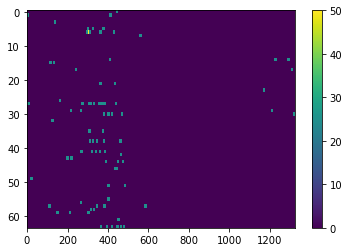

In [121]:
plt.imshow(fr_data[:,:,outlier_ind].T, aspect = 'auto', cmap = 'viridis')
plt.colorbar()

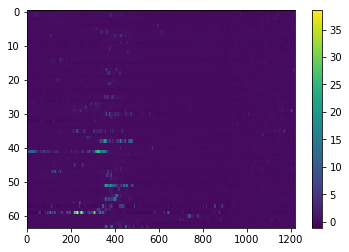

In [124]:
plt.imshow(fr_e2e[:,:,outlier_ind].T, aspect = 'auto', cmap = 'viridis')
plt.colorbar()

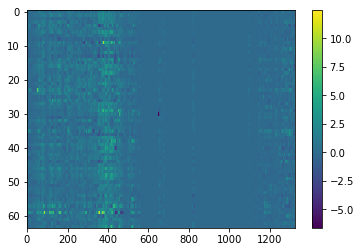

In [125]:
plt.imshow(fr_embed[:,:,outlier_ind].T, aspect = 'auto', cmap = 'viridis')
plt.colorbar()

In [96]:


print(e2e_uids)
print(embed_trial_inds)
print(marker_trial_inds)

True
['SC-SC035-20200108-48' 'SC-SC035-20200108-324' 'SC-SC035-20200108-101'
 'SC-SC035-20200108-47' 'SC-SC035-20200108-224' 'SC-SC035-20200108-570'
 'SC-SC035-20200108-226' 'SC-SC035-20200108-563' 'SC-SC035-20200108-607'
 'SC-SC035-20200108-129' 'SC-SC035-20200108-161' 'SC-SC035-20200108-274'
 'SC-SC035-20200108-114' 'SC-SC035-20200108-466' 'SC-SC035-20200108-139'
 'SC-SC035-20200108-136' 'SC-SC035-20200108-193' 'SC-SC035-20200108-544'
 'SC-SC035-20200108-152' 'SC-SC035-20200108-254' 'SC-SC035-20200108-494'
 'SC-SC035-20200108-556' 'SC-SC035-20200108-501' 'SC-SC035-20200108-552'
 'SC-SC035-20200108-322' 'SC-SC035-20200108-437' 'SC-SC035-20200108-164'
 'SC-SC035-20200108-300' 'SC-SC035-20200108-462' 'SC-SC035-20200108-619'
 'SC-SC035-20200108-545' 'SC-SC035-20200108-110' 'SC-SC035-20200108-21'
 'SC-SC035-20200108-383' 'SC-SC035-20200108-64' 'SC-SC035-20200108-498'
 'SC-SC035-20200108-286' 'SC-SC035-20200108-581' 'SC-SC035-20200108-50'
 'SC-SC035-20200108-138' 'SC-SC035-20200108-309' 'S

In [93]:
e2e_trial_alignment_inds

[4,
 6,
 7,
 29,
 18,
 45,
 41,
 31,
 25,
 1,
 27,
 51,
 44,
 8,
 16,
 21,
 38,
 15,
 20,
 28,
 9,
 3,
 19,
 23,
 12,
 42,
 61,
 49,
 62,
 50,
 26,
 60,
 56,
 59,
 35,
 47,
 22,
 2,
 40,
 46,
 39,
 32,
 37,
 30,
 13,
 43,
 36,
 53,
 10,
 48,
 34,
 5,
 33,
 17,
 11,
 55,
 63,
 0,
 57,
 24,
 58,
 52,
 14,
 54]

In [95]:
np.array(e2e_trial_inds)[e2e_trial_alignment_inds]

array([223, 225, 562, 618, 151, 140, 175, 109, 436, 323, 299, 561, 600,
       606, 192, 555,  49, 135, 493, 461, 128,  46, 253, 551, 113, 620,
       405,  10, 387, 364, 163, 267, 403, 304, 497, 538, 500, 100, 308,
       601, 137,  20, 580, 544, 465, 303, 285, 309, 160, 354,  63, 569,
       382, 543, 273, 325, 120,  47, 559, 321, 178, 628, 138, 343])

In [94]:
embed_trial_inds

array([559, 128, 580, 555,  47, 561, 323, 100, 465, 493, 354, 343, 321,
       600, 387, 543, 138, 309, 223, 500, 151, 135, 285, 551, 304, 606,
       544, 160, 253,  46, 303, 562, 175, 628, 364,  63, 601, 620, 192,
       308,  49, 225, 436, 140, 113, 569, 137, 497,  10, 299, 618, 273,
       405, 538, 120, 325,  20, 178, 267, 382, 109, 163, 461, 403])

In [89]:
for ii in e2e_trial_inds:
    if ii not in embed_trial_inds:
        print(ii)

In [43]:
embed_data['ccf_unit_ids']

[3,
 9,
 12,
 14,
 19,
 21,
 22,
 24,
 26,
 28,
 30,
 31,
 33,
 40,
 43,
 44,
 46,
 47,
 51,
 55,
 57,
 58,
 59,
 60,
 61,
 63,
 68,
 70,
 75,
 79,
 80,
 82,
 89,
 92,
 93,
 95,
 96,
 107,
 111,
 114,
 116,
 120,
 121,
 122,
 124,
 125,
 126,
 127,
 128,
 131,
 132,
 134,
 140,
 148,
 149,
 150,
 151,
 153,
 159,
 161,
 172,
 175,
 176,
 179,
 180,
 181,
 183,
 184,
 185,
 186,
 188,
 190,
 191,
 193,
 194,
 199,
 203,
 204,
 206,
 2,
 5,
 8,
 11,
 18,
 19,
 21,
 26,
 27,
 28,
 31,
 34,
 36,
 37,
 39,
 42,
 43,
 47,
 48,
 49,
 50,
 51,
 56,
 62,
 63,
 65,
 66,
 67,
 69,
 70,
 71,
 72,
 75,
 78,
 83,
 84,
 86,
 89,
 90,
 92,
 93,
 95,
 96,
 101,
 105,
 107,
 117,
 123,
 137,
 149,
 150,
 151,
 157,
 160,
 166,
 171,
 178,
 185,
 188,
 193,
 200,
 205,
 206,
 215,
 219,
 220,
 221,
 222,
 228,
 229,
 231,
 234,
 236,
 241,
 243,
 249,
 254,
 260,
 264,
 265,
 269,
 270,
 276,
 293,
 304,
 305,
 313,
 344,
 69,
 71,
 73,
 78,
 81,
 83,
 84,
 85,
 86,
 103,
 104,
 107,
 111,
 351,
 354,
 3

In [44]:
ephys_data['ccf_unit_id']

[3,
 9,
 12,
 14,
 19,
 21,
 22,
 24,
 26,
 28,
 30,
 31,
 33,
 40,
 43,
 44,
 46,
 47,
 51,
 55,
 57,
 58,
 59,
 60,
 61,
 63,
 68,
 70,
 75,
 79,
 80,
 82,
 89,
 92,
 93,
 95,
 96,
 107,
 111,
 114,
 116,
 120,
 121,
 122,
 124,
 125,
 126,
 127,
 128,
 131,
 132,
 134,
 140,
 148,
 149,
 150,
 151,
 153,
 159,
 161,
 172,
 175,
 176,
 179,
 180,
 181,
 183,
 184,
 185,
 186,
 188,
 190,
 191,
 193,
 194,
 199,
 203,
 204,
 206]

In [52]:
save_fname = '../data/combined_methods_r2.pickle'
combined_data = pickle.load(open(save_fname, 'rb'))

In [53]:
combined_data.keys()

dict_keys(['r2_e2e_response', 'r2_embed_response', 'r2_marker_response', 'r2_e2e_sample', 'r2_embed_sample', 'r2_marker_sample', 'r2_e2e_delay', 'r2_embed_delay', 'r2_marker_delay', 'ccf_label', 'ccf_coords', 'session_name', 'is_alm', 'avg_fr', 'file_name'])

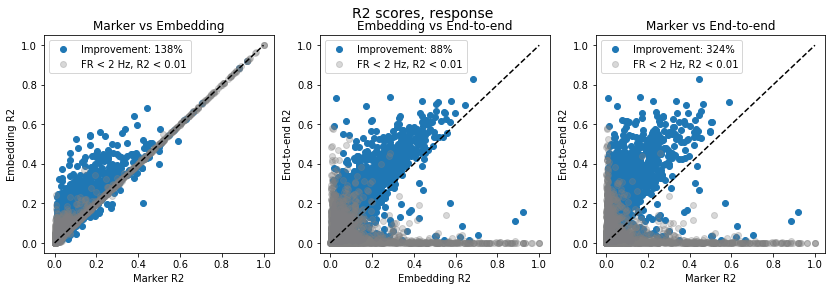

<ipython-input-6-5f2ffc4f3636>:17: RuntimeWarning: divide by zero encountered in true_divide
  ratio = (embed - marker)/marker
<ipython-input-6-5f2ffc4f3636>:17: RuntimeWarning: invalid value encountered in true_divide
  ratio = (embed - marker)/marker
<ipython-input-6-5f2ffc4f3636>:27: RuntimeWarning: divide by zero encountered in true_divide
  ratio = (e2e - embed)/embed
<ipython-input-6-5f2ffc4f3636>:27: RuntimeWarning: invalid value encountered in true_divide
  ratio = (e2e - embed)/embed
<ipython-input-6-5f2ffc4f3636>:37: RuntimeWarning: divide by zero encountered in true_divide
  ratio = (e2e - marker)/marker
<ipython-input-6-5f2ffc4f3636>:37: RuntimeWarning: invalid value encountered in true_divide
  ratio = (e2e - marker)/marker


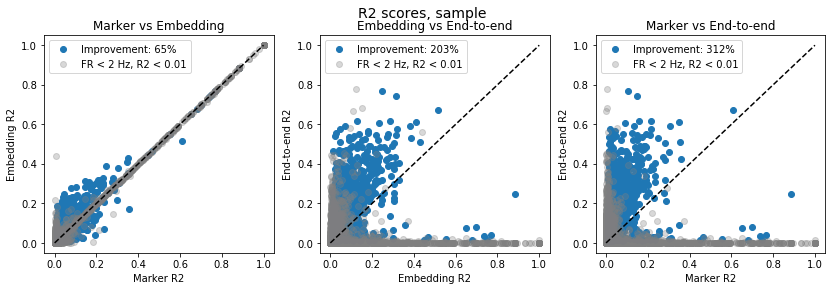

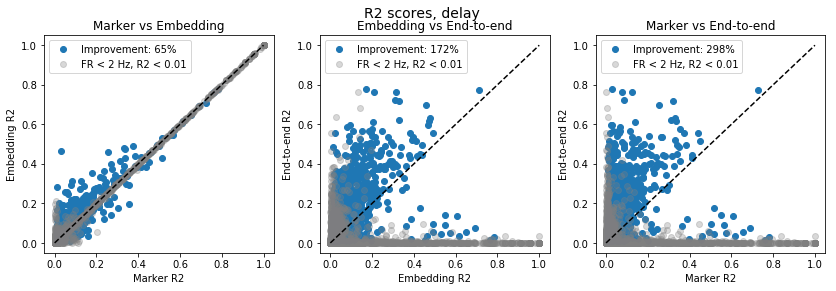

In [6]:

for epoch in ['response','sample','delay']:

    embed = combined_data['r2_embed_%s'%epoch]
    marker = combined_data['r2_marker_%s'%epoch]
    e2e = combined_data['r2_e2e_%s'%epoch]
    fr = combined_data['avg_fr']

    fr_filter = fr > 2
    r2_filter = (embed > 0.01) & (marker > 0.01) & (e2e > 0.01)
    filter = fr_filter & r2_filter

    f,_=plt.subplots(1,3,figsize=(14,4))
    f.suptitle('R2 scores, %s'%epoch, fontsize = 14)

    plt.subplot(1,3,1)
    plt.title('Marker vs Embedding')
    ratio = (embed - marker)/marker
    plt.plot(marker[filter],embed[filter],'o', label = 'Improvement: %.0f%%'%np.mean(ratio[filter]*100))
    plt.plot(marker[~filter],embed[~filter],'o',c = 'grey', alpha = .3, label = 'FR < 2 Hz, R2 < 0.01')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('Marker R2')
    plt.ylabel('Embedding R2')
    plt.legend()

    plt.subplot(1,3,2)
    plt.title('Embedding vs End-to-end')
    ratio = (e2e - embed)/embed
    plt.plot(embed[filter],e2e[filter],'o', label = 'Improvement: %.0f%%'%np.mean(ratio[filter]*100))
    plt.plot(embed[~filter],e2e[~filter],'o',c = 'grey', alpha = .3, label = 'FR < 2 Hz, R2 < 0.01')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('Embedding R2')
    plt.ylabel('End-to-end R2')
    plt.legend()

    plt.subplot(1,3,3)
    plt.title('Marker vs End-to-end')
    ratio = (e2e - marker)/marker
    plt.plot(marker[filter],e2e[filter],'o', label = 'Improvement: %.0f%%'%np.mean(ratio[filter]*100))
    plt.plot(marker[~filter],e2e[~filter],'o',c = 'grey', alpha = .3, label = 'FR < 2 Hz, R2 < 0.01')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('Marker R2')
    plt.ylabel('End-to-end R2')
    plt.legend()

    plt.savefig('../figs/end_to_end/r2_scatters_%s.png'%epoch, dpi = 300, bbox_inches = 'tight')
    plt.show()
    plt.close()

## Look for exceptionally good/bad e2e predictable neurons

The good ones bc reviewers asked the bad ones bc I want to understand.

In [12]:
save_fname = '../data/combined_methods_r2_new.pickle'
combined_data = pickle.load(open(save_fname, 'rb'))
combined_data.keys()

dict_keys(['r2_e2e_response', 'r2_embed_response', 'r2_marker_response', 'r2_e2e_sample', 'r2_embed_sample', 'r2_marker_sample', 'r2_e2e_delay', 'r2_embed_delay', 'r2_marker_delay', 'ccf_label', 'ccf_coords', 'session_name', 'is_alm', 'avg_fr', 'response_fr', 'delay_fr', 'sample_fr', 'file_name'])

In [26]:
epoch = 'response'
embed = combined_data['r2_embed_%s'%epoch]
marker = combined_data['r2_marker_%s'%epoch]
e2e = combined_data['r2_e2e_%s'%epoch]
fr = combined_data['%s_fr'%epoch]
session_names = combined_data['session_name']
filenames = combined_data['file_name']

_filter = (fr > 2) & (embed > 0.01) & (marker > 0.01) & (e2e > 0.01)

filter_inds = np.where(_filter)[0]
filtered_embed = embed[_filter]
filtered_marker = marker[_filter]
filtered_e2e = e2e[_filter]
filtered_fr = fr[_filter]
filtered_session = session_names[_filter]
filtered_fnames = filenames[_filter]

In [27]:
# spearman correlation between fr and embed and e2e R2 scores
from scipy.stats import spearmanr
r_embed_fr,p_embed_fr = spearmanr(filtered_embed,filtered_fr)
r_e2e_fr,p_e2e_fr = spearmanr(filtered_e2e,filtered_fr)
r_e2e_embed_ratio_fr, p_e2e_embed_ratio_fr = spearmanr((filtered_e2e - filtered_embed)/filtered_embed,filtered_fr)

print('Spearman correlation')
print('Embedding vs FR: ',(r_embed_fr,p_embed_fr))
print('End-to-end vs FR: ',(r_e2e_fr,p_e2e_fr))
print('End-to-end improvement vs FR: ',(r_e2e_embed_ratio_fr,p_e2e_embed_ratio_fr))

Spearman correlation
Embedding vs FR:  (0.3965766712073965, 1.0367856091987847e-144)
End-to-end vs FR:  (0.42701001828726604, 6.915559746259998e-170)
End-to-end improvement vs FR:  (-0.003392370528273575, 0.8336149767821494)


In [28]:
ratio_embed_marker = (filtered_embed - filtered_marker)/filtered_marker
ratio_e2e_embed = (filtered_e2e - filtered_embed)/filtered_embed
ratio_e2e_marker = (filtered_e2e - filtered_marker)/filtered_marker

sort_inds = np.argsort(ratio_e2e_embed)

print(ratio_e2e_embed[sort_inds][:10])
print(filtered_embed[sort_inds][:10])
print(filtered_e2e[sort_inds][:10])
print(filtered_fr[sort_inds][:10])
print(filtered_session[sort_inds][:10])
print(filtered_fnames[sort_inds][:10])

print(ratio_e2e_embed[sort_inds][-10:])
print(filtered_embed[sort_inds][-10:])
print(filtered_e2e[sort_inds][-10:])
print(filtered_fr[sort_inds][-10:])
print(filtered_session[sort_inds][-10:])
print(filtered_fnames[sort_inds][-10:])

[-0.95763767 -0.89314235 -0.83925251 -0.79440538 -0.78633033 -0.74701873
 -0.74690988 -0.74409196 -0.74213232 -0.73956281]
[0.35506989 0.10504495 0.086937   0.12149398 0.23104711 0.11560284
 0.28144384 0.06209243 0.55256095 0.04945702]
[0.01504159 0.01122486 0.01397491 0.02497851 0.04936776 0.02924535
 0.07123066 0.01588995 0.14248761 0.01288045]
[2.78758306 2.46184593 2.62536337 3.03285922 2.3619186  2.57734635
 3.77777201 8.83772841 2.10626038 6.82490656]
['SC065_20210514_13' 'SC030_20191003_33' 'SC052_20210126_7'
 'SC066_20210415_8' 'SC067_20210420_28' 'SC030_20191005_35'
 'SC049_20210108_16' 'SC064_20210430_8' 'SC035_20200108_34'
 'SC060_20210322_4']
['SC065_20210514_left_Striatum.pickle'
 'SC030_20191003_left_Medulla.pickle'
 'SC052_20210126_right_Thalamus.pickle' 'SC066_20210415_left_ALM.pickle'
 'SC067_20210420_left_Medulla.pickle' 'SC030_20191005_left_Medulla.pickle'
 'SC049_20210108_right_Striatum.pickle'
 'SC064_20210430_left_Striatum.pickle'
 'SC035_20200108_right_Medulla.pi

In [29]:

N = 50
rand_inds = np.random.choice(np.arange(len(filtered_embed)),N)

In [30]:
def collect_single_neurons_of_interest(inds, file_name_array, ):
    save_dict = {}
    for i in inds:
        _this_file = file_name_array[i]
        first_ind = np.min(np.where(file_name_array == _this_file)[0])
        _this_ind = i - first_ind
        save_dict[i] = {'file_name': _this_file, 'neuron_ind': _this_ind}
    return save_dict


In [31]:
best_50_inds = collect_single_neurons_of_interest(filter_inds[sort_inds][-50:], filenames)
worst_50_inds = collect_single_neurons_of_interest(filter_inds[sort_inds][:50], filenames)

os.makedirs('../data/end_to_end/', exist_ok = True)
pickle.dump(best_50_inds, open('../data/end_to_end/best_50_inds.pickle', 'wb'))
pickle.dump(worst_50_inds, open('../data/end_to_end/worst_50_inds.pickle', 'wb'))

In [32]:
best_neurons_data = pickle.load(open('../data/end_to_end/best_e2e_single_neuron_data.pickle', 'rb'))

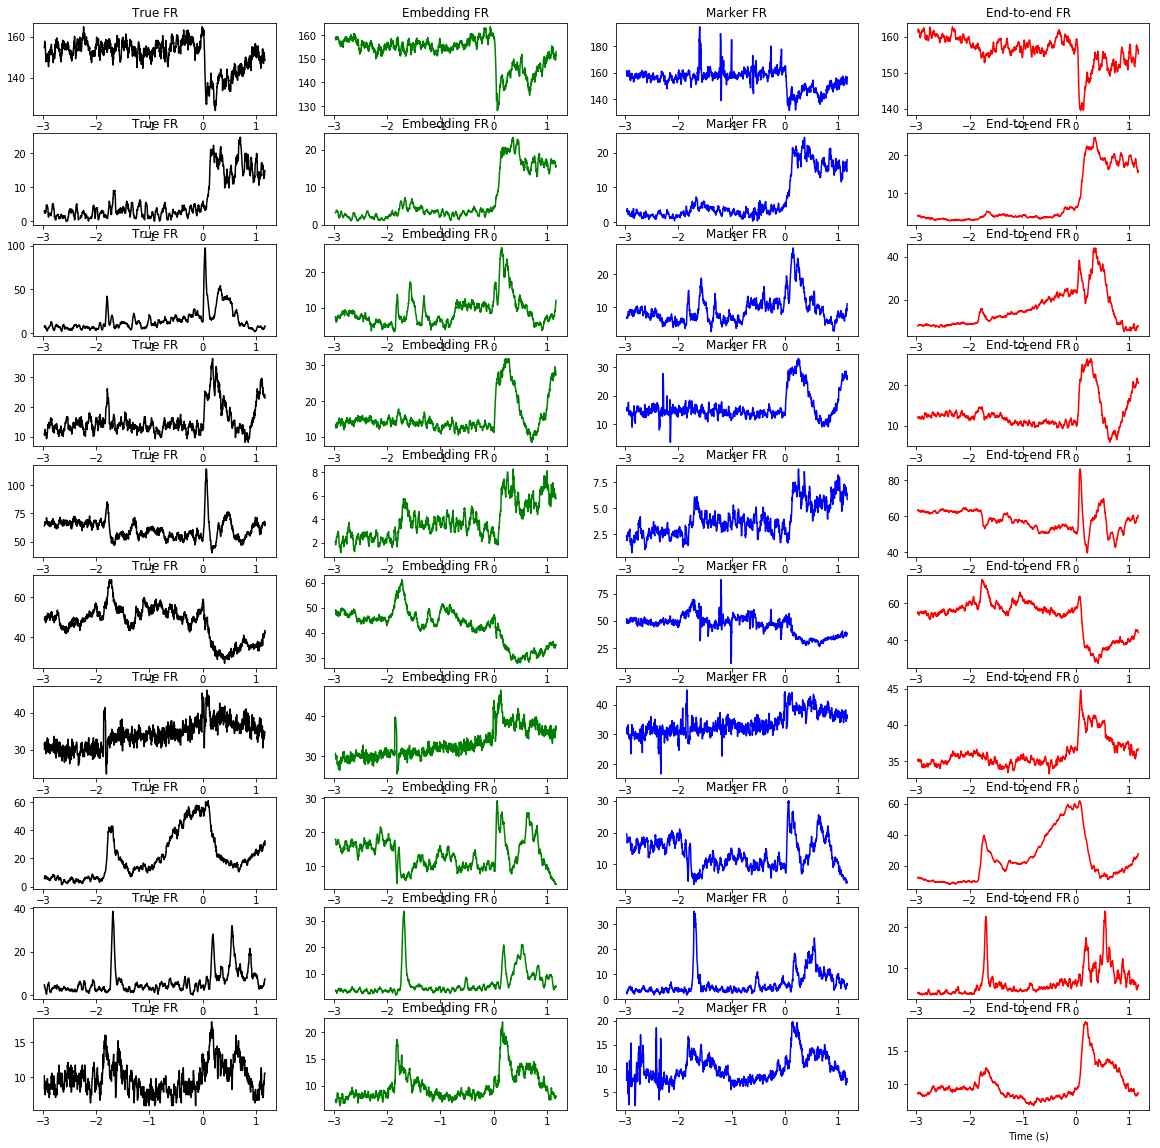

In [33]:
n = 10

plt.subplots(n,4, figsize = (20,20))

for i, (k,v) in enumerate(best_neurons_data.items()):
    plt.subplot(n,4,i*4+1)
    plt.plot(v['tt'],v['fr_true'].mean(axis=1), 'k-')
    plt.title('True FR')
    plt.subplot(n,4,i*4+2)
    plt.plot(v['tt'],v['fr_embed'].mean(axis = 1), 'g-')
    plt.title('Embedding FR')
    plt.subplot(n,4,i*4+3)
    plt.plot(v['tt'],v['fr_marker'].mean(axis = 1), 'b-')
    plt.title('Marker FR')
    plt.subplot(n,4,i*4+4)
    plt.plot(v['tt'],v['fr_e2e'].mean(axis = 1), 'r-')
    plt.title('End-to-end FR')
    if i == n-1:
        plt.xlabel('Time (s)')
        break

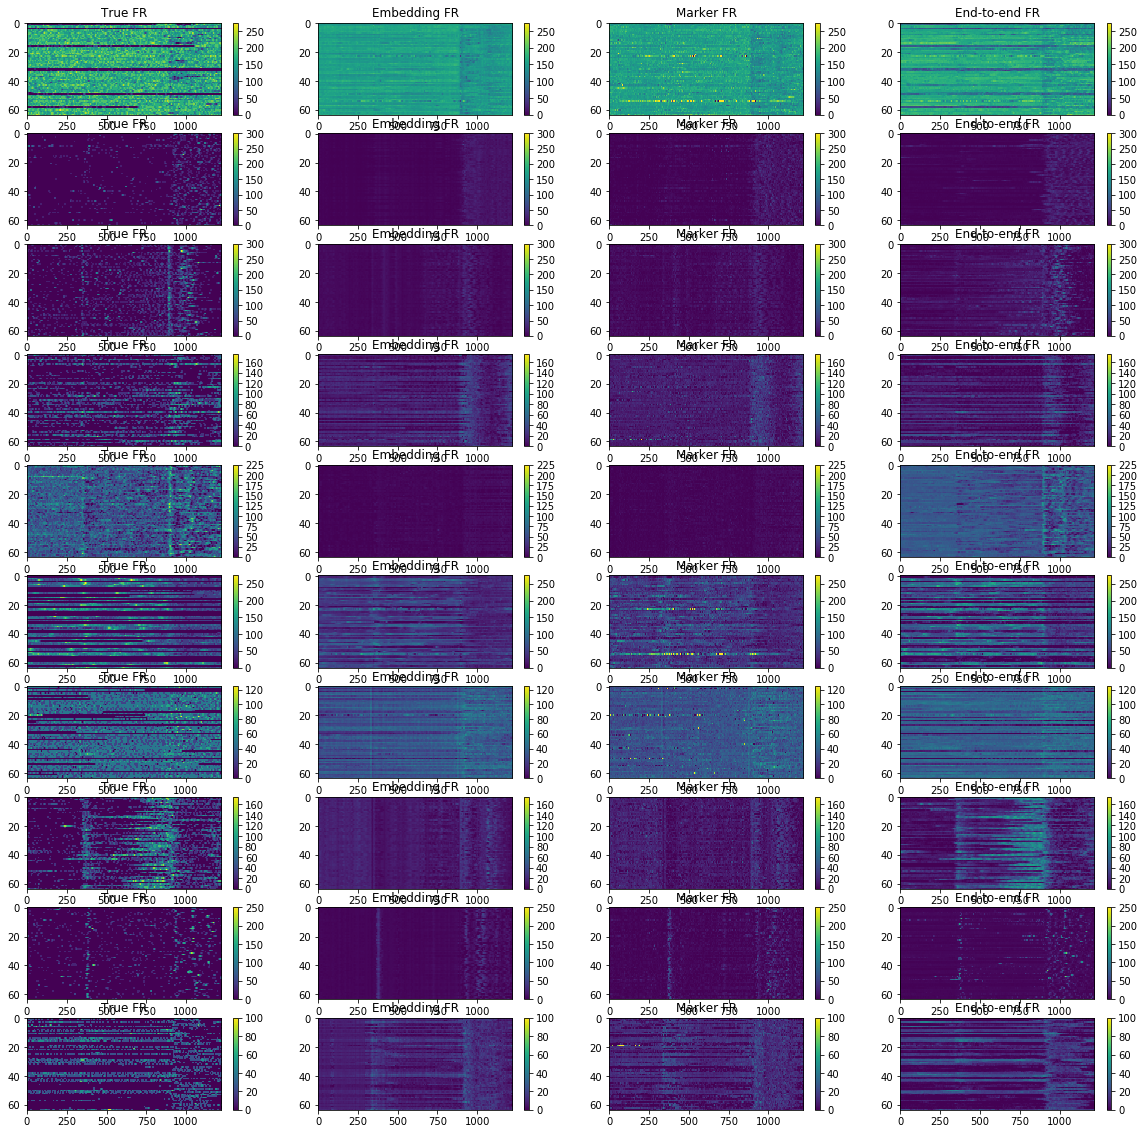

In [34]:
n = 10

plt.subplots(n,4, figsize = (20,20))

for i, (k,v) in enumerate(best_neurons_data.items()):
    plt.subplot(n,4,i*4+1)
    vmin = np.min(v['fr_true'])
    vmax = np.max(v['fr_true'])
    plt.imshow(v['fr_true'].T, aspect='auto', vmin = vmin, vmax = vmax)
    plt.colorbar()
    plt.title('True FR')
    plt.subplot(n,4,i*4+2)
    plt.imshow(v['fr_embed'].T, aspect = 'auto', vmin = vmin, vmax = vmax)
    plt.colorbar()
    plt.title('Embedding FR')
    plt.subplot(n,4,i*4+3)
    plt.imshow(v['fr_marker'].T, aspect='auto',  vmin = vmin, vmax = vmax)
    plt.colorbar()
    plt.title('Marker FR')
    plt.subplot(n,4,i*4+4)
    plt.imshow(v['fr_e2e'].T, aspect='auto',  vmin = vmin, vmax = vmax)
    plt.colorbar()
    plt.title('End-to-end FR')
    if i == n-1:
        break

In [35]:
worst_neurons_data = pickle.load(open('../data/end_to_end/worst_e2e_single_neuron_data.pickle', 'rb'))

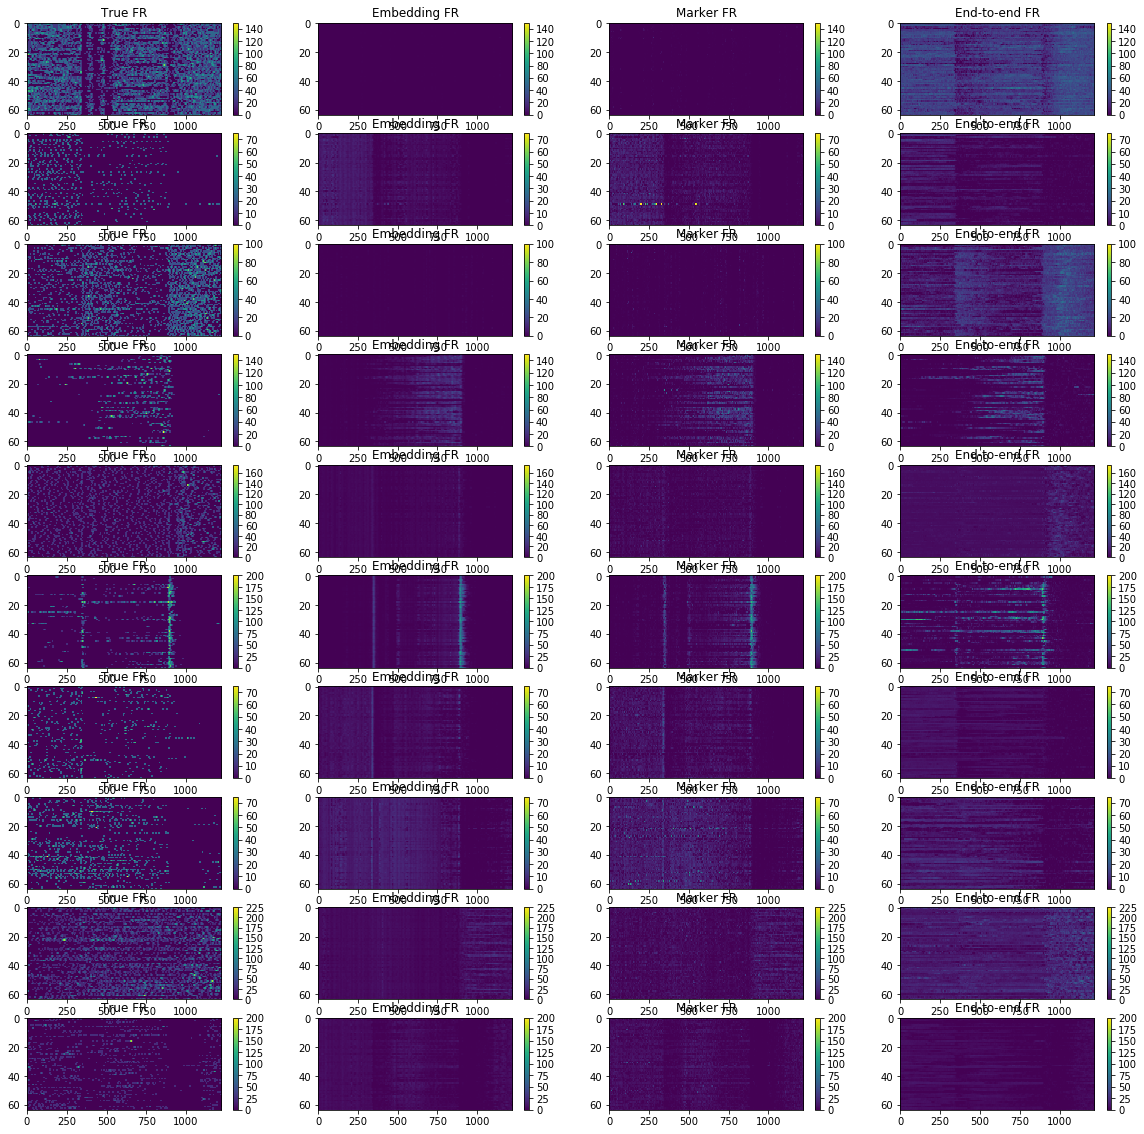

In [36]:
n = 10

plt.subplots(n,4, figsize = (20,20))

for i, (k,v) in enumerate(worst_neurons_data.items()):
    plt.subplot(n,4,i*4+1)
    vmin = np.min(v['fr_true'])
    vmax = np.max(v['fr_true'])
    plt.imshow(v['fr_true'].T, aspect='auto', vmin = vmin, vmax = vmax)
    plt.colorbar()
    plt.title('True FR')
    plt.subplot(n,4,i*4+2)
    plt.imshow(v['fr_embed'].T, aspect = 'auto', vmin = vmin, vmax = vmax)
    plt.colorbar()
    plt.title('Embedding FR')
    plt.subplot(n,4,i*4+3)
    plt.imshow(v['fr_marker'].T, aspect='auto',  vmin = vmin, vmax = vmax)
    plt.colorbar()
    plt.title('Marker FR')
    plt.subplot(n,4,i*4+4)
    plt.imshow(v['fr_e2e'].T, aspect='auto',  vmin = vmin, vmax = vmax)
    plt.colorbar()
    plt.title('End-to-end FR')
    if i == n-1:
        break

In [51]:
ind = 3222

data = worst_neurons_data[ind]

tt = data['tt']
fr_true = data['fr_true']
fr_embed = data['fr_embed']
fr_marker = data['fr_marker']
fr_e2e = data['fr_e2e']

In [52]:
data

{'tt': array([-2.9728, -2.9694, -2.966 , ...,  1.165 ,  1.1684,  1.1718]),
 'fr_true': array([[ 75.,  75.,  75., ...,  25.,  75.,   0.],
        [ 50., 100., 100., ...,  25.,  75.,   0.],
        [ 50.,  75., 100., ...,  25.,  75.,  25.],
        ...,
        [ 25.,  50.,  50., ...,   0.,  25.,  25.],
        [ 25.,  50.,  50., ...,   0.,  25.,  25.],
        [ 25.,  50.,  25., ...,   0.,  25.,  25.]]),
 'fr_embed': array([[ 0.11264543,  0.07704695,  0.2652826 , ...,  0.12783959,
          0.11911773,  0.13942669],
        [ 0.11207469,  0.07637194,  0.26531508, ...,  0.12692527,
          0.11924172,  0.13905261],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.08119387,  0.21086858,  0.01805987, ...,  0.3151031 ,
         -0.00388685,  0.00399277],
        [ 0.05893702,  0.21842761,  0.03202485, ...,  0.31861477,
          0.01127329,  0.0145842 ],
        [ 0.04306571,  0.22827912,  0.04305902, ...,  0.32

In [53]:
np.unique([d['fname'] for d in list(worst_neurons_data.values())])

array(['SC027_20190730_left_Midbrain.pickle',
       'SC027_20190731_left_Midbrain.pickle',
       'SC027_20190803_left_Striatum.pickle',
       'SC027_20190804_right_Striatum.pickle',
       'SC030_20191003_left_Medulla.pickle',
       'SC030_20191005_left_Medulla.pickle',
       'SC031_20191021_right_Medulla.pickle',
       'SC031_20191023_left_Medulla.pickle',
       'SC032_20191218_left_ALM.pickle',
       'SC035_20200108_right_Medulla.pickle',
       'SC035_20200109_right_Midbrain.pickle',
       'SC035_20200110_right_Midbrain.pickle',
       'SC045_20201218_left_Thalamus.pickle',
       'SC048_20201225_right_Midbrain.pickle',
       'SC048_20201226_left_ALM.pickle',
       'SC049_20210108_right_Striatum.pickle',
       'SC050_20210227_right_ALM.pickle',
       'SC050_20210302_left_Striatum.pickle',
       'SC053_20210222_left_Striatum.pickle',
       'SC060_20210322_right_Striatum.pickle',
       'SC061_20210321_right_Striatum.pickle',
       'SC061_20210322_right_ALM.pickle',
  

In [54]:
worst_neurons_data.keys()

dict_keys([3222, 1620, 3215, 2777, 1162, 3933, 3344, 6079, 1442, 1318, 1496, 773, 6765, 7204, 6769, 5589, 8036, 3554, 8001, 5033, 5601, 3337, 6905, 8017, 5109, 6719, 781, 1516, 2511, 5032, 8088, 3085, 3688, 2884, 1191, 8003, 2572, 2896, 330, 6791, 7256, 3523, 1146, 6841, 1581, 8273, 6702, 3603, 4876, 1515])

In [55]:
e2e[list(worst_neurons_data.keys())] / embed[list(worst_neurons_data.keys())] -1

array([-0.91581436,  2.44577408,  3.36570338,  0.69786712,  0.58210342,
       -1.        , -0.03031341,  3.14216303,  2.14693833,  0.43152104,
       -0.99394332,  0.4582525 ,  1.03329559,  0.57298584,  0.71654972,
        0.46490982,  0.48274108, -0.99673051, -0.08088262,  4.31474577,
       -0.49932432, -0.13851169,  1.37010971,  0.44671605,  0.68096099,
        1.88819212,  1.70032126,  1.85135428,  0.38159937,  2.34460793,
        2.25567525,  4.00466791,  0.4713762 ,  0.68166543,  0.50340452,
        1.78319882,  0.46130747,  2.62611587,  2.85336496,  0.32877054,
       -0.91080652, -0.63958135,  0.36323856,  0.6434407 , -0.01973536,
        3.02618794,  0.31100548,  0.03597187,  0.47053137,  0.29766679])

In [56]:
len(filter_inds)

3837

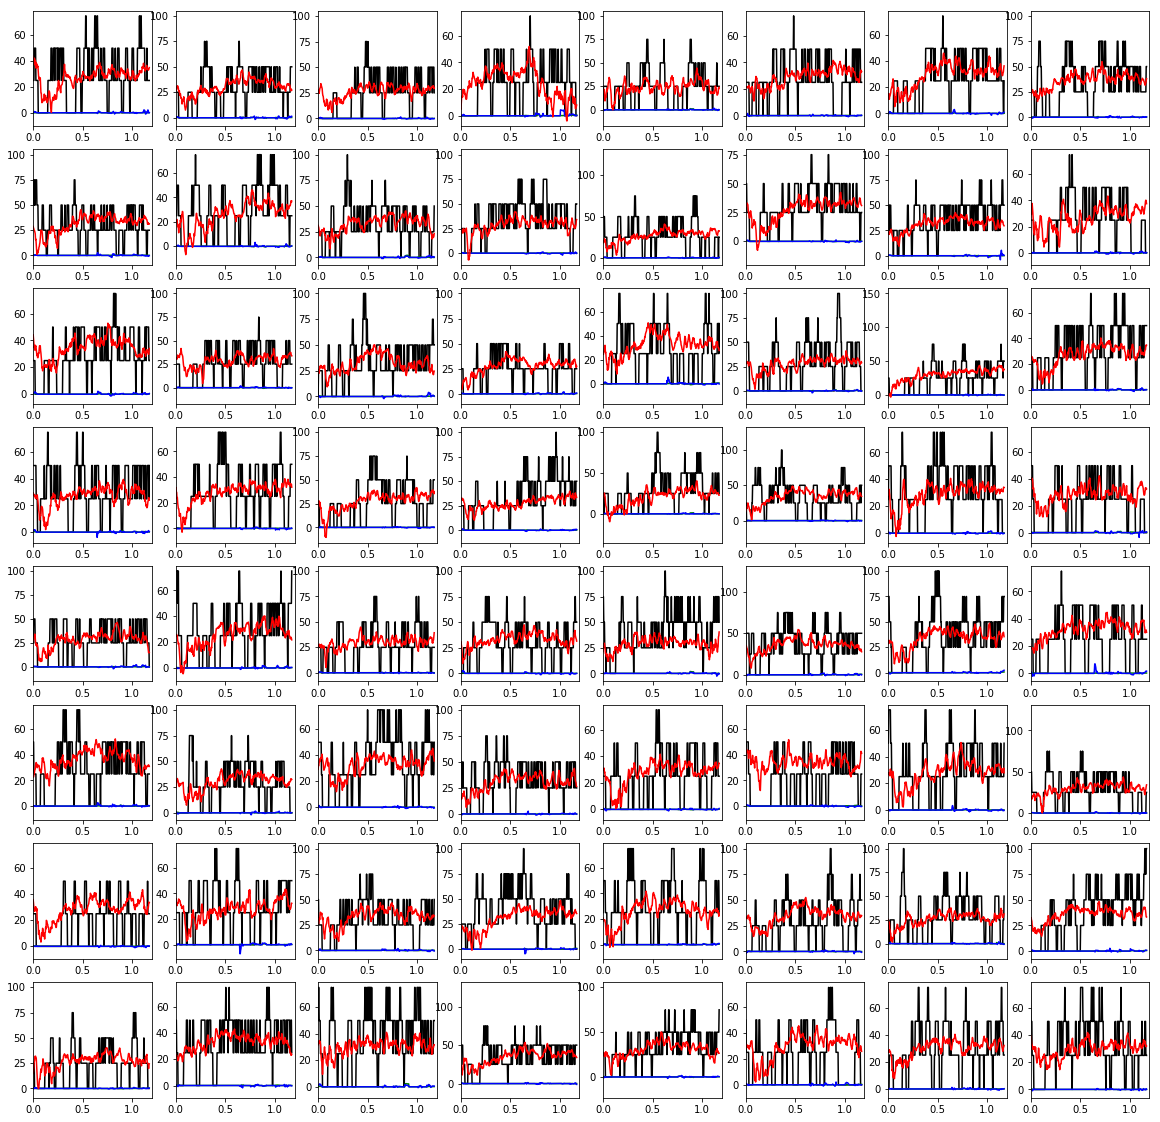

In [57]:
plt.subplots(8,8, figsize = (20,20))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.plot(tt,fr_true[:,i],'k-')
    plt.plot(tt,fr_embed[:,i],'g-')
    plt.plot(tt,fr_marker[:,i],'b-')
    plt.plot(tt,fr_e2e[:,i],'r-')
    plt.xlim(0,1.2)
    #plt.axis('off')

In [58]:
embed[ind], marker[ind], e2e[ind]

(0.1037363117173123, 0.10001897043511351, 0.008733107652079382)

In [59]:
# r2 score
from sklearn.metrics import r2_score

r2_embed = np.array([r2_score(fr_true[t],fr_embed[t],) for t in range(fr_true.shape[0])])
r2_marker = np.array([r2_score(fr_true[t],fr_marker[t],) for t in range(fr_true.shape[0])])
r2_e2e = np.array([r2_score(fr_true[t],fr_e2e[t],) for t in range(fr_true.shape[0])])

response_mask = (tt >= 0.15) & (tt <= 1.2)

relu = lambda x: np.maximum(x,0)

response_r2_embed = relu(r2_embed)[response_mask].mean()
response_r2_marker = relu(r2_marker)[response_mask].mean()
response_r2_e2e = relu(r2_e2e)[response_mask].mean()

response_r2_embed, response_r2_marker, response_r2_e2e

(0.0, 0.0, 0.013033336362519184)

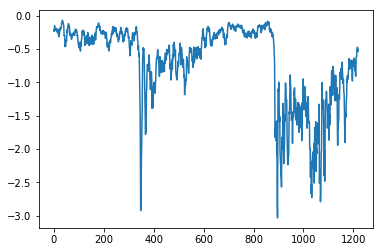

In [25]:
plt.plot(r2_embed)

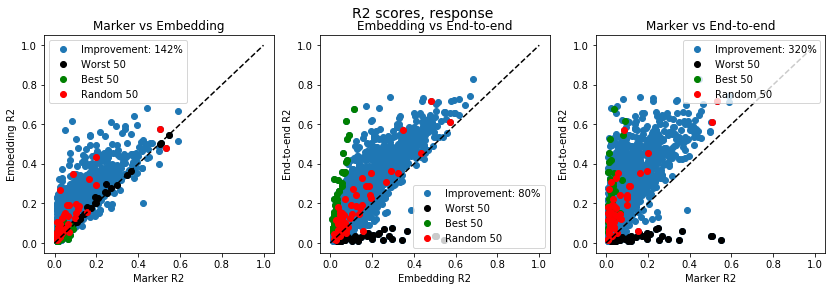

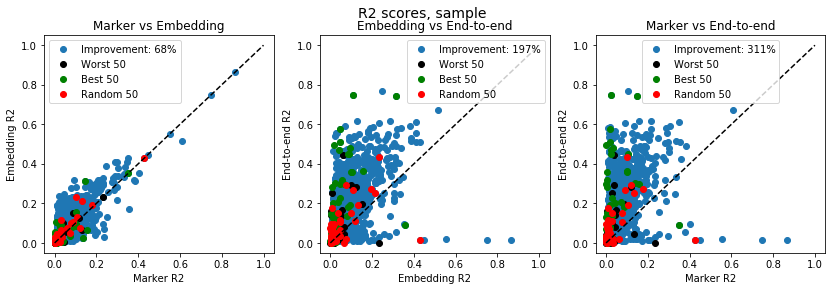

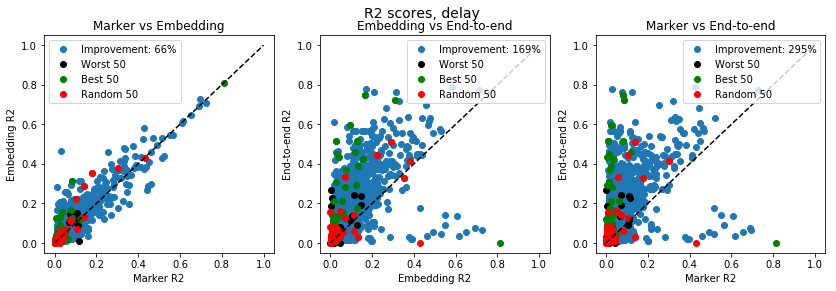

In [9]:

for epoch in ['response','sample','delay']:

    embed = combined_data['r2_embed_%s'%epoch]
    marker = combined_data['r2_marker_%s'%epoch]
    e2e = combined_data['r2_e2e_%s'%epoch]
    fr = combined_data['avg_fr']

    filtered_embed = embed[_filter]
    filtered_marker = marker[_filter]
    filtered_e2e = e2e[_filter]

    fr_filter = fr > 2
    r2_filter = (embed > 0.01) & (marker > 0.01) & (e2e > 0.01)
    filter = fr_filter & r2_filter

    f,_=plt.subplots(1,3,figsize=(14,4))
    f.suptitle('R2 scores, %s'%epoch, fontsize = 14)

    plt.subplot(1,3,1)
    plt.title('Marker vs Embedding')
    ratio = (embed[filter] - marker[filter])/marker[filter]
    plt.plot(marker[filter],embed[filter],'o', label = 'Improvement: %.0f%%'%np.mean(ratio*100))
    #plt.plot(marker[~filter],embed[~filter],'o',c = 'grey', alpha = .3, label = 'FR < 2 Hz, R2 < 0.01')
    plt.plot(filtered_marker[sort_inds][:N],filtered_embed[sort_inds][:N],'o',c = 'k', label = 'Worst %d'%N)
    plt.plot(filtered_marker[sort_inds][-N:],filtered_embed[sort_inds][-N:],'o',c = 'green', label = 'Best %d'%N)
    plt.plot(filtered_marker[rand_inds],filtered_embed[rand_inds],'o',c = 'red', label = 'Random %d'%N)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('Marker R2')
    plt.ylabel('Embedding R2')
    plt.legend()

    plt.subplot(1,3,2)
    plt.title('Embedding vs End-to-end')
    ratio = (e2e[filter] - embed[filter])/embed[filter]
    plt.plot(embed[filter],e2e[filter],'o', label = 'Improvement: %.0f%%'%np.mean(ratio*100))
    #plt.plot(embed[~filter],e2e[~filter],'o',c = 'grey', alpha = .3, label = 'FR < 2 Hz, R2 < 0.01')
    plt.plot(filtered_embed[sort_inds][:N],filtered_e2e[sort_inds][:N],'o',c = 'k', label = 'Worst %d'%N)
    plt.plot(filtered_embed[sort_inds][-N:],filtered_e2e[sort_inds][-N:],'o',c = 'green', label = 'Best %d'%N)
    plt.plot(filtered_embed[rand_inds],filtered_e2e[rand_inds],'o',c = 'red', label = 'Random %d'%N)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('Embedding R2')
    plt.ylabel('End-to-end R2')
    plt.legend()

    plt.subplot(1,3,3)
    plt.title('Marker vs End-to-end')
    ratio = (e2e[filter] - marker[filter])/marker[filter]
    plt.plot(marker[filter],e2e[filter],'o', label = 'Improvement: %.0f%%'%np.mean(ratio*100))
    #plt.plot(marker[~filter],e2e[~filter],'o',c = 'grey', alpha = .3, label = 'FR < 2 Hz, R2 < 0.01')
    plt.plot(filtered_marker[sort_inds][:N],filtered_e2e[sort_inds][:N],'o',c = 'k', label = 'Worst %d'%N)
    plt.plot(filtered_marker[sort_inds][-N:],filtered_e2e[sort_inds][-N:],'o',c = 'green', label = 'Best %d'%N)
    plt.plot(filtered_marker[rand_inds],filtered_e2e[rand_inds],'o',c = 'red', label = 'Random %d'%N)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('Marker R2')
    plt.ylabel('End-to-end R2')
    plt.legend()

    #plt.savefig('../figs/end_to_end/r2_scatters_%s.png'%epoch, dpi = 300, bbox_inches = 'tight')
    plt.show()
    plt.close()